## Import

In [73]:
from music21 import converter, pitch

# Load the MusicXML file
file_path = "/workspaces/codespaces-jupyter/music/_Later_-_Rene_Liu_.mxl"
# file_path = "/workspaces/codespaces-jupyter/music/music_box_adapted_oct_shift.mxl" # Replace with your actual file path
score = converter.parse(file_path)

In [74]:
# Create a set to store unique notes
unique_notes = set()

# Iterate through all notes in the score
for note_obj in score.recurse().notes:
    # Handle both individual notes and chords
    if note_obj.isChord:
        # For chords, process each pitch in the chord
        for pitch_obj in note_obj.pitches:
            unique_notes.add(pitch_obj.nameWithOctave)
    elif note_obj.isNote:
        # For individual notes, add the pitch
        unique_notes.add(note_obj.pitch.nameWithOctave)

# Define a sorting function that sorts by octave and then by pitch class (C to B)
def pitch_sort_key(note_name):
    p = pitch.Pitch(note_name)
    # This sorts first by octave, then by diatonic pitch number (C=0, D=1, etc.)
    return (p.octave, p.pitchClass)

# Sort the notes using our custom function
sorted_unique_notes = sorted(unique_notes, key=pitch_sort_key)
print(sorted_unique_notes)

['E-2', 'F2', 'G2', 'A-2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'A-3', 'B-3', 'C-3', 'C4', 'D4', 'E-4', 'F4', 'G4', 'A-4', 'B-4', 'C-4', 'C5', 'D5', 'E-5', 'F5', 'G5', 'A-5', 'B-5', 'C-5', 'C6']


In [75]:
# List to hold positions of C4
positions = []
# Iterate through all elements in the score that are considered notes
for elem in score.recurse().notes:
    # Only proceed if elem is an instance of note.Note (ignoring chord symbols, rests, etc.)
    if isinstance(elem, note.Note):
        # Compare the pitch (for example, looking for C4)
        if elem.pitch == pitch.Pitch('A2'):
            # Get the containing measure for the note
            measure = elem.getContextByClass('Measure')
            if measure is not None:
                positions.append((measure.measureNumber, elem.offset))

print("Positions of C-3 in the score (measure, offset):")
for pos in positions:
    print(pos)

AttributeError: 'str' object has no attribute 'Note'

In [76]:
# Group notes by octave
grouped_notes = {}
for note in sorted_unique_notes:
    # Get the octave number from the note name
    octave = int(''.join(filter(str.isdigit, note)))
    if octave not in grouped_notes:
        grouped_notes[octave] = []
    grouped_notes[octave].append(note)

# Iterate thru each key (octave) in the dictionary
print("Dictionary", grouped_notes, "\n", sep="\n")
print("Sorted by octave")
for octave in sorted(grouped_notes.keys()):
    print(" ".join(grouped_notes[octave]))

Dictionary
{2: ['E-2', 'F2', 'G2', 'A-2', 'B-2'], 3: ['C3', 'D3', 'E-3', 'F3', 'G3', 'A-3', 'B-3', 'C-3'], 4: ['C4', 'D4', 'E-4', 'F4', 'G4', 'A-4', 'B-4', 'C-4'], 5: ['C5', 'D5', 'E-5', 'F5', 'G5', 'A-5', 'B-5', 'C-5'], 6: ['C6']}


Sorted by octave
E-2 F2 G2 A-2 B-2
C3 D3 E-3 F3 G3 A-3 B-3 C-3
C4 D4 E-4 F4 G4 A-4 B-4 C-4
C5 D5 E-5 F5 G5 A-5 B-5 C-5
C6


In [77]:
music_box_notes = [
    'C', 'D', 'G', 'A', 'B',
    'C1', 'D1', 'E1', 'F1', 'F#1', 'G1', 'G#1', 'A1', 'A#1', 'B1',
    'C2', 'C#2', 'D2', 'D#2', 'E2', 'F2', 'F#2', 'G2', 'G#2', 'A2', 'A#2', 'B2',
    'C3', 'D3', 'E3'
]

## Note comparison

In [78]:
def convert_to_music_box_notation(note_name):
    # Parse the note using music21
    p = pitch.Pitch(note_name)
    
    # Extract letter, accidental, and octave
    letter = p.step
    
    # Handle accidental
    if p.accidental is not None:
        if p.accidental.name == 'sharp':
            acc = '#'
        elif p.accidental.name == 'flat':
            # Always convert flat to equivalent sharp when possible
            flat_to_sharp = {
                'E': ('D', '#'),
                'B': ('A', '#'),
                'A': ('G', '#'),
                'D': ('C', '#'),
                'G': ('F', '#'),
                'C': ('B', ''),  # Special case: Cb -> B
                'F': ('E', '')   # Special case: Fb -> E
            }
            
            if letter in flat_to_sharp:
                # Get the new note and accidental
                new_letter, new_acc = flat_to_sharp[letter]
                
                # Adjust octave if needed (for C-flat and F-flat)
                octave_adj = -1 if letter in ['C', 'F'] else 0
                p = pitch.Pitch(new_letter + new_acc + str(p.octave + octave_adj))
                letter = p.step
                acc = new_acc
            else:
                acc = 'b'  # Keep flat if no conversion defined
        else:
            acc = ''
    else:
        acc = ''
    
    # Reset octave (music21's C2 = music box's C)
    music_box_octave = p.octave - 2
    
    # Format according to music box notation
    if music_box_octave <= 0:
        return letter + acc
    else:
        return letter + acc + str(music_box_octave)

# Convert each note and check if it's available on the music box
converted_notes = []
availability = []

for note in sorted_unique_notes:
    music_box_note = convert_to_music_box_notation(note)
    converted_notes.append((note, music_box_note))
    if music_box_note in music_box_notes:
        availability.append("Available")
    else:
        availability.append("Not Available")

# Group notes by octave (using music21 octave for grouping)
grouped_notes = {}
for note, music_box_note, avail in zip(sorted_unique_notes, [n[1] for n in converted_notes], availability):
    p = pitch.Pitch(note)
    octave = str(p.octave)
    
    if octave not in grouped_notes:
        grouped_notes[octave] = []
    
    grouped_notes[octave].append((note, music_box_note, avail))

# Print the results in a nice side-by-side format
print("\nNote Comparison by Octave:\n")
print(f"{'Music21 Note':<12} {'Music Box Note':<14} {'Availability':<15}")
print("-" * 42)

for octave in sorted(grouped_notes.keys()):
    print(f"\nOctave {octave}:")
    for note, music_box_note, avail in grouped_notes[octave]:
        print(f"{note:<12} {music_box_note:<14} {avail:<15}")

# Print summary
available_count = availability.count("Available")
print(f"\nSummary: {available_count} out of {len(sorted_unique_notes)} notes are available on your music box.")
print(f"Coverage: {available_count/len(sorted_unique_notes)*100:.1f}%")

# List unavailable notes
unavailable_notes = [converted_notes[i][1] for i, avail in enumerate(availability) if avail == "Not Available"]
if unavailable_notes:
    print("\nUnavailable notes in music box notation:")
    print(", ".join(unavailable_notes))


Note Comparison by Octave:

Music21 Note Music Box Note Availability   
------------------------------------------

Octave 2:
E-2          D#             Not Available  
F2           F              Not Available  
G2           G              Available      
A-2          G#             Not Available  
B-2          A#             Not Available  

Octave 3:
C3           C1             Available      
D3           D1             Available      
E-3          D#1            Not Available  
F3           F1             Available      
G3           G1             Available      
A-3          G#1            Available      
B-3          A#1            Available      
C-3          B              Available      

Octave 4:
C4           C2             Available      
D4           D2             Available      
E-4          D#2            Available      
F4           F2             Available      
G4           G2             Available      
A-4          G#2            Available      
B-4          A#

In [79]:
# Add after your existing summary
print("\nAvailability Chart:")
for octave in sorted(grouped_notes.keys()):
    octave_notes = [n[0] for n in grouped_notes[octave]]
    octave_avail = [n[2] == "Available" for n in grouped_notes[octave]]
    
    print(f"Octave {octave}: ", end="")
    for note, avail in zip(octave_notes, octave_avail):
        # Print available notes in green, unavailable in red (if in terminal that supports color)
        marker = "✓" if avail else "✗"
        print(f"{note}({marker}) ", end="")
    print()


Availability Chart:
Octave 2: E-2(✗) F2(✗) G2(✓) A-2(✗) B-2(✗) 
Octave 3: C3(✓) D3(✓) E-3(✗) F3(✓) G3(✓) A-3(✓) B-3(✓) C-3(✓) 
Octave 4: C4(✓) D4(✓) E-4(✓) F4(✓) G4(✓) A-4(✓) B-4(✓) C-4(✓) 
Octave 5: C5(✓) D5(✓) E-5(✗) F5(✗) G5(✗) A-5(✗) B-5(✗) C-5(✓) 
Octave 6: C6(✗) 


## TRANPOSITION ANALYSIS FOR ENTIRE SONG

In [80]:
print("\nTransposition Analysis:")
for semitones in range(-8, 9):
    if semitones == 0:
        continue  # Skip original key
        
    transposed_notes = []
    for note in sorted_unique_notes:
        p = pitch.Pitch(note)
        p.transpose(semitones, inPlace=True)
        transposed_note = convert_to_music_box_notation(p.nameWithOctave)
        transposed_notes.append(transposed_note)
    
    avail_count = sum(1 for note in transposed_notes if note in music_box_notes)
    print(f"Transposing by {semitones:+d} semitones: {avail_count}/{len(sorted_unique_notes)} notes available ({avail_count/len(sorted_unique_notes)*100:.1f}%)")


Transposition Analysis:
Transposing by -8 semitones: 26/30 notes available (86.7%)
Transposing by -7 semitones: 17/30 notes available (56.7%)
Transposing by -6 semitones: 22/30 notes available (73.3%)
Transposing by -5 semitones: 21/30 notes available (70.0%)
Transposing by -4 semitones: 18/30 notes available (60.0%)
Transposing by -3 semitones: 24/30 notes available (80.0%)
Transposing by -2 semitones: 16/30 notes available (53.3%)
Transposing by -1 semitones: 21/30 notes available (70.0%)
Transposing by +1 semitones: 18/30 notes available (60.0%)
Transposing by +2 semitones: 20/30 notes available (66.7%)
Transposing by +3 semitones: 16/30 notes available (53.3%)
Transposing by +4 semitones: 21/30 notes available (70.0%)
Transposing by +5 semitones: 16/30 notes available (53.3%)
Transposing by +6 semitones: 19/30 notes available (63.3%)
Transposing by +7 semitones: 17/30 notes available (56.7%)
Transposing by +8 semitones: 16/30 notes available (53.3%)


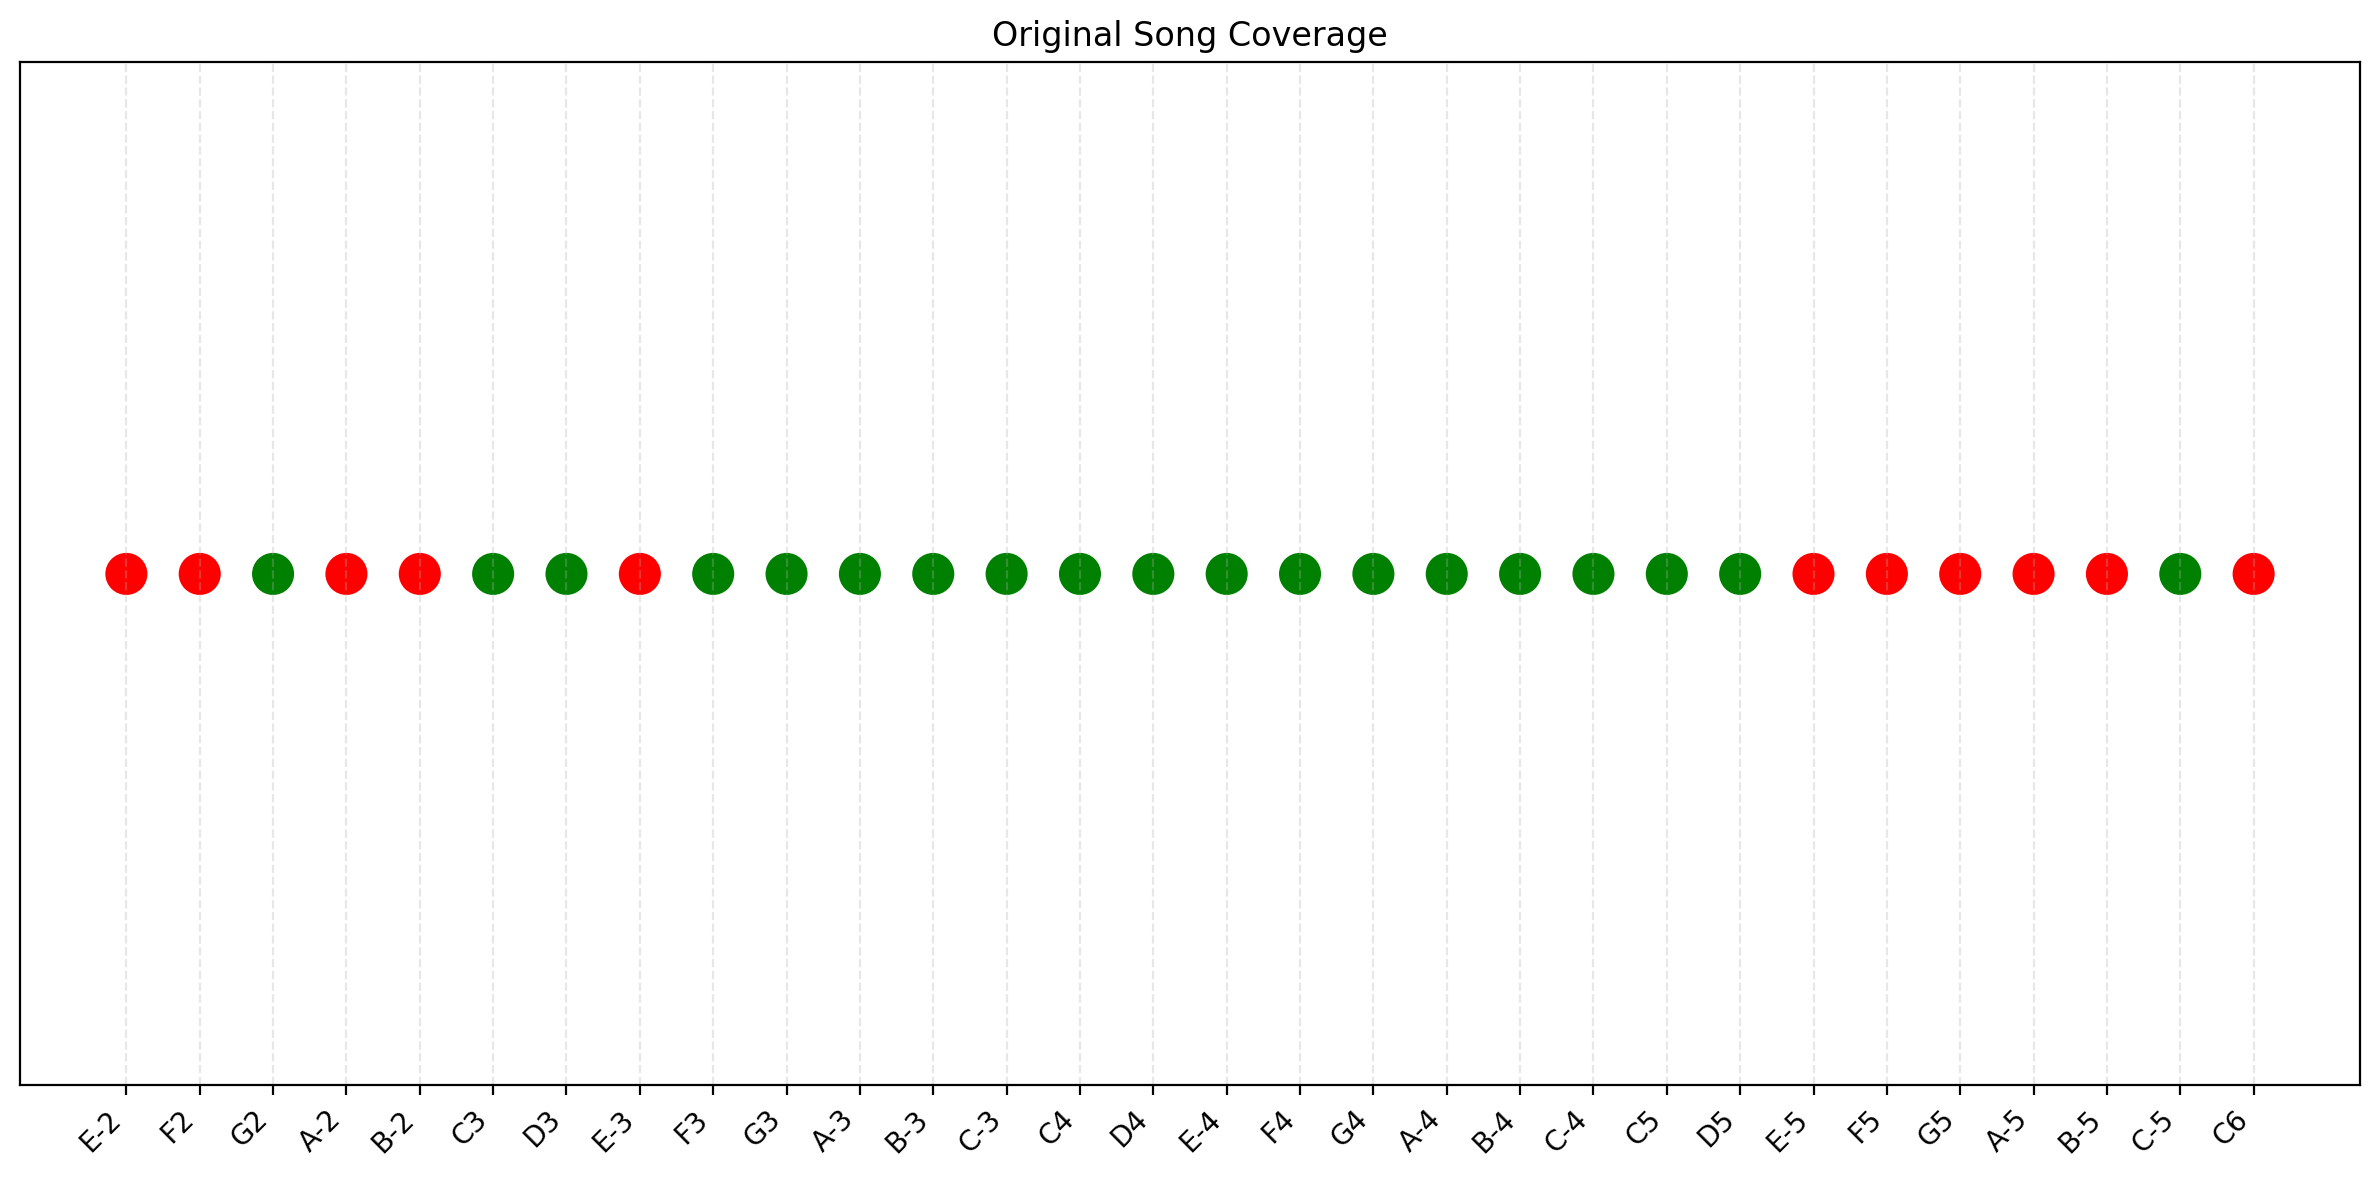

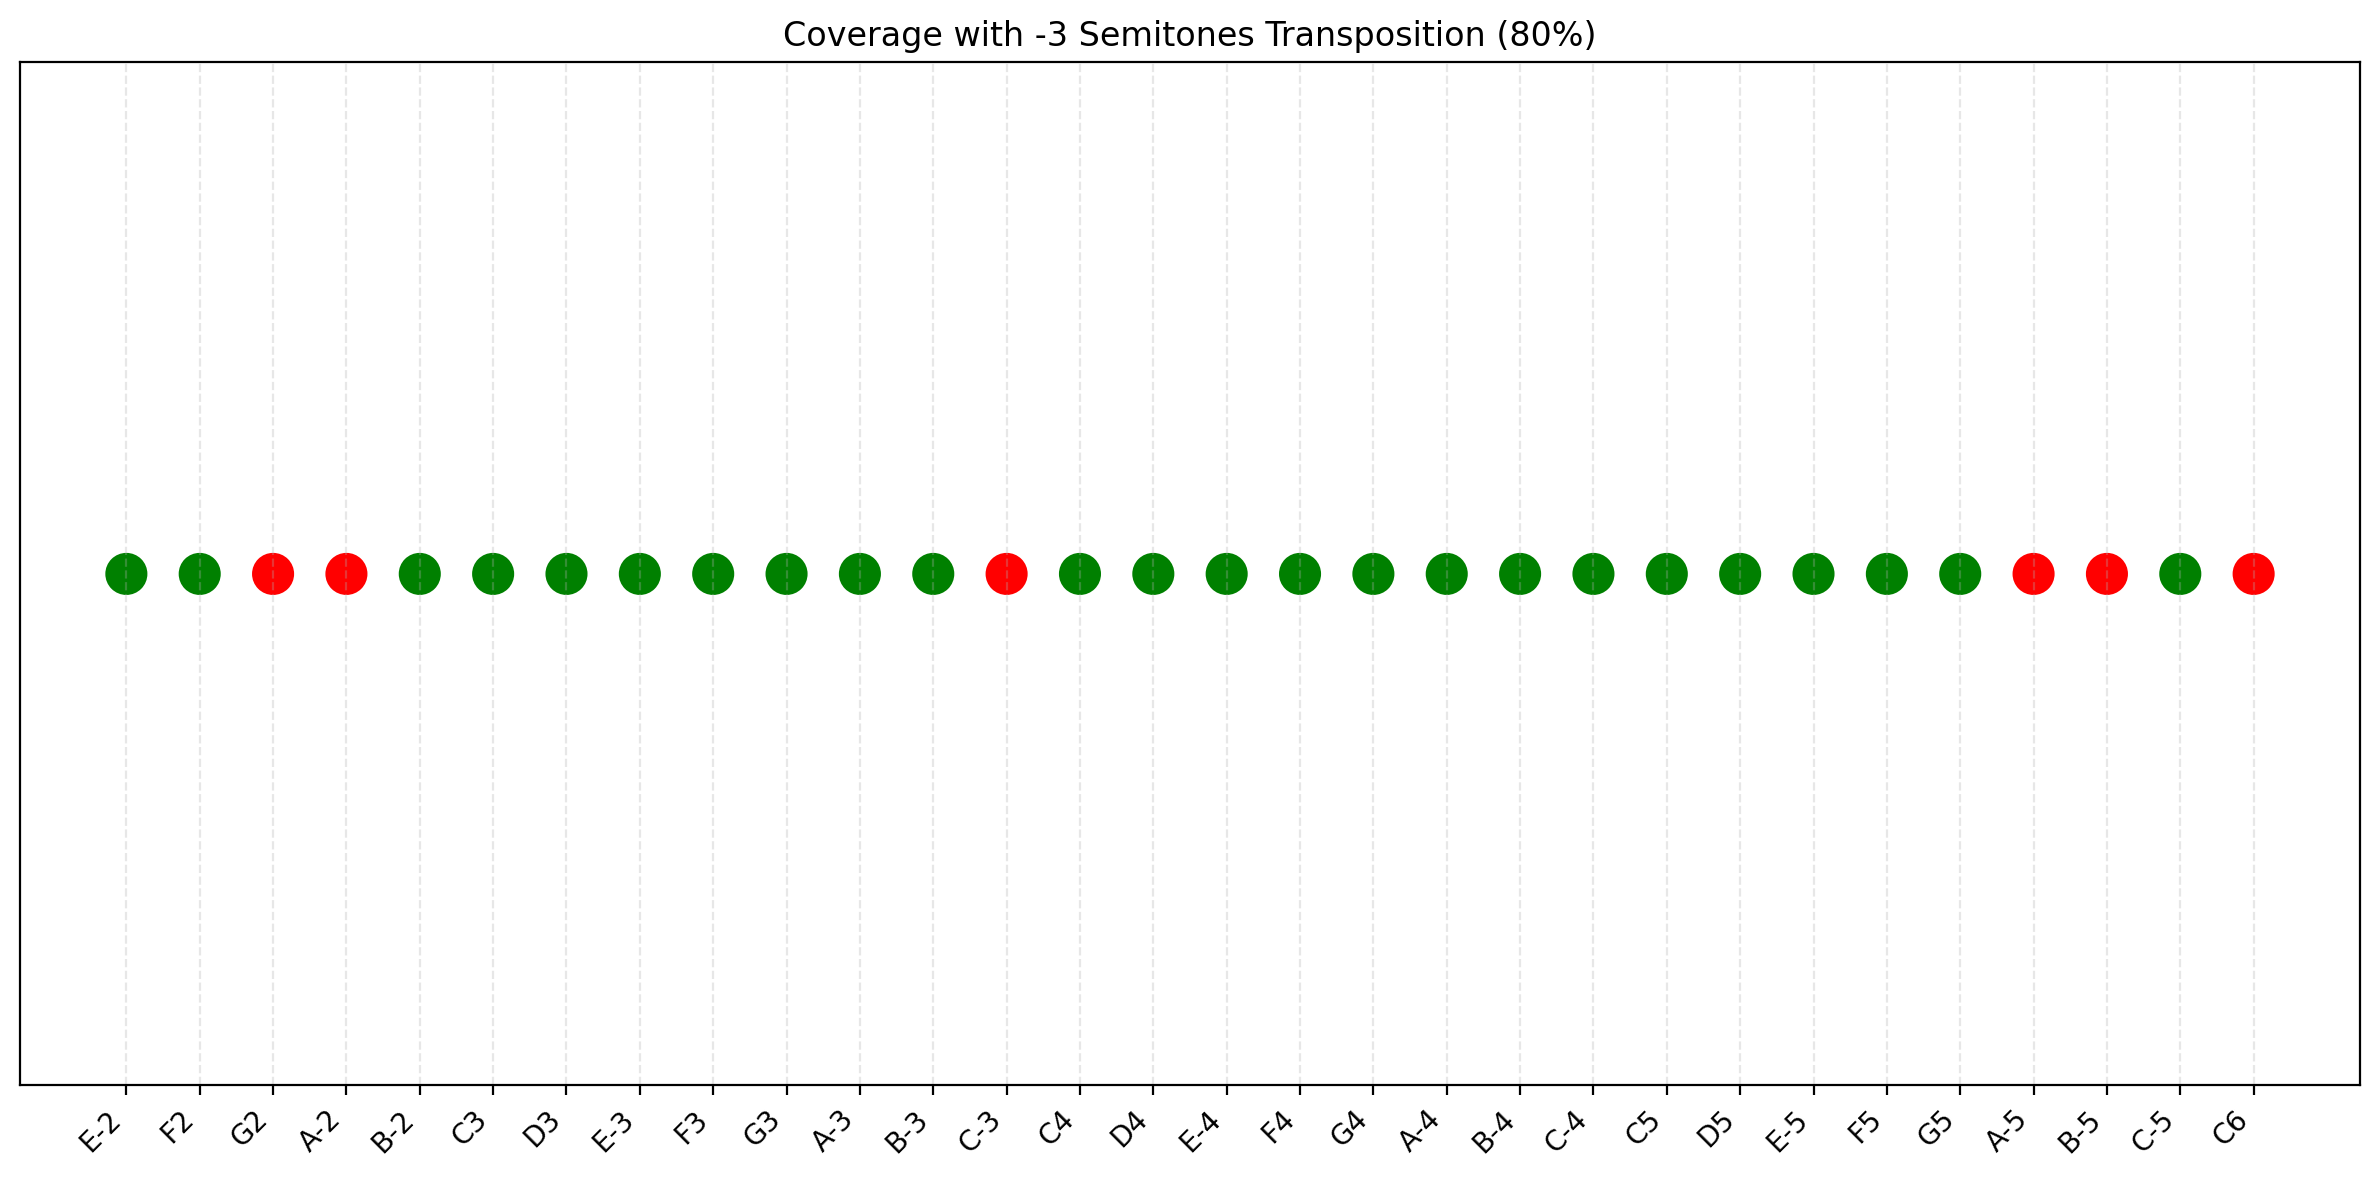

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import os
from music21 import stream, note, chord, expressions, pitch, converter
import shutil

# Create directories for outputs
os.makedirs("/workspaces/codespaces-jupyter/music/sections", exist_ok=True)
os.makedirs("/workspaces/codespaces-jupyter/music/divided_parts", exist_ok=True)

def plot_coverage_graph(notes, availability, title):
    plt.figure(figsize=(12, 6))
    x_positions = np.arange(len(notes))
    colors = ['green' if avail else 'red' for avail in availability]
    plt.scatter(x_positions, [1]*len(notes), s=200, c=colors)
    plt.xticks(x_positions, notes, rotation=45, ha='right')
    plt.yticks([])
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Current coverage with original notes
current_availability = [convert_to_music_box_notation(note) in music_box_notes for note in sorted_unique_notes]
plot_coverage_graph(sorted_unique_notes, current_availability, "Original Song Coverage")

# Analyze with -3 semitones (best from previous analysis)
transposed_availability = []
for note in sorted_unique_notes:
    p = pitch.Pitch(note)
    p.transpose(-3, inPlace=True)
    transposed_availability.append(convert_to_music_box_notation(p.nameWithOctave) in music_box_notes)

plot_coverage_graph(sorted_unique_notes, transposed_availability, "Coverage with -3 Semitones Transposition (80%)")

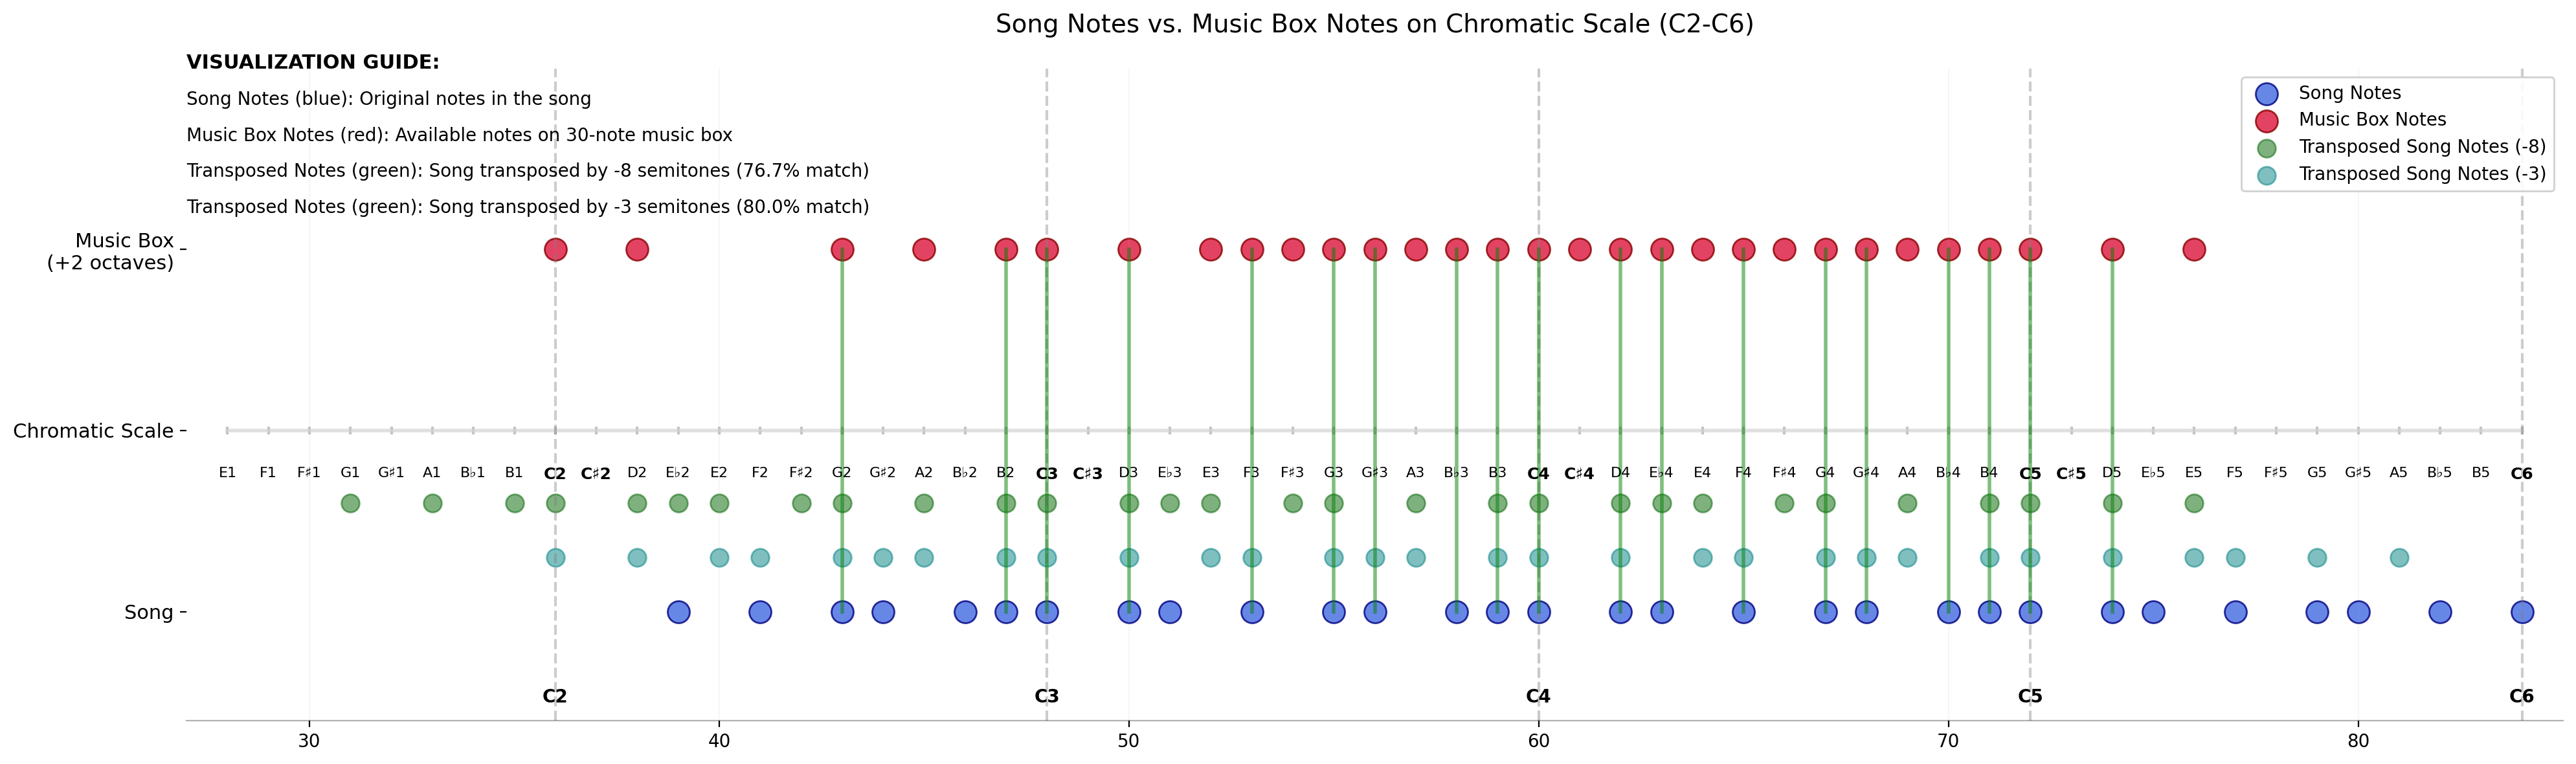

In [82]:
import matplotlib.pyplot as plt
import numpy as np
from music21 import pitch

def create_improved_chromatic_chart():
    """Create a cleaner, more aligned chromatic reference chart"""
    # Create full chromatic scale C2 to C6
    all_notes = []
    all_midi_numbers = []
    
    # Start with C2 (MIDI 36) and go to C6 (MIDI 84)
    for midi_num in range(28, 85):
        p = pitch.Pitch()
        p.midi = midi_num
        all_notes.append(p.nameWithOctave)
        all_midi_numbers.append(midi_num)
    
    # Create a figure with proper size and better aspect ratio
    plt.figure(figsize=(20, 6))
    
    # Create more space between elements
    row_positions = {
        'song': 1.0,
        'reference': 2.0,
        'music_box': 3.0,
        'oct': 2.6
    }
    
    # Plot the reference scale as a clear horizontal line
    plt.plot([28, 84], [row_positions['reference'], row_positions['reference']], 
             color='lightgray', linewidth=2, alpha=0.7)
    plt.scatter(all_midi_numbers, [row_positions['reference']] * len(all_notes), 
                s=20, color='darkgray', alpha=0.7, marker='|')
    
    # Get song notes and convert to MIDI numbers
    song_notes_midi = []
    for note_name in sorted_unique_notes:
        p = pitch.Pitch(note_name)
        song_notes_midi.append(p.midi)
    
    # Plot song notes with a stronger color and better contrast
    plt.scatter(song_notes_midi, [row_positions['song']] * len(song_notes_midi), 
                s=150, color='royalblue', alpha=0.8, marker='o', edgecolor='navy', label='Song Notes')
    
    # Convert music box notes to proper format and shift up 2 octaves
    music_box_midi = []
    for note in music_box_notes:
        # Parse the note and add 2 octaves
        if note.isalpha() or (len(note) > 1 and note[-1] == '#'):
            adj_note = note + '2'
        else:
            note_part = ''.join([c for c in note if c.isalpha() or c == '#'])
            octave_part = int(''.join([c for c in note if c.isdigit()]))
            adj_note = note_part + str(octave_part + 2)
            
        p = pitch.Pitch(adj_note)
        music_box_midi.append(p.midi)
    
    # Plot music box notes with a stronger color and better contrast
    plt.scatter(music_box_midi, [row_positions['music_box']] * len(music_box_midi), 
                s=150, color='crimson', alpha=0.8, marker='o', edgecolor='darkred', label='Music Box Notes')
    
    # Add clearer octave dividers
    for octave in range(2, 7):
        midi_num = (octave * 12) + 12  # C for each octave
        plt.axvline(x=midi_num, color='gray', linestyle='--', alpha=0.4)
        plt.text(midi_num, 0.5, f"C{octave}", ha='center', fontweight='bold', fontsize=10)
    
    # Mark key notes on the reference scale
    for midi_num in range(28, 85):
        p = pitch.Pitch()
        p.midi = midi_num
        note_name = p.nameWithOctave
        
        # Only label C, E, G, and B more prominently
        if 'C' in note_name:
            plt.text(midi_num, row_positions['reference'] - 0.2, note_name.replace('-', '♭').replace('#', '♯'), 
                     ha='center', va='top', fontsize=9, fontweight='bold')
        # elif any(x in note_name for x in ['E', 'G']):
        else:
            plt.text(midi_num, row_positions['reference'] - 0.2, note_name.replace('-', '♭').replace('#', '♯'), 
                        ha='center', va='top', fontsize=8)
    
    # Mark areas of overlap with clearer connecting lines
    for midi_num in set(song_notes_midi).intersection(set(music_box_midi)):
        plt.plot([midi_num, midi_num], 
                 [row_positions['song'], row_positions['music_box']], 
                 'g-', alpha=0.5, linewidth=2)
    
    # Visualize the best transposition more clearly
    oct_transpose = -8
    shifted_oct_midi = [m + oct_transpose for m in song_notes_midi]
    plt.scatter(shifted_oct_midi, [row_positions['song'] + 0.6] * len(shifted_oct_midi), 
                s=100, color='darkgreen', alpha=0.5, marker='o', label='Transposed Song Notes (-8)')
    tri_transpose = -3
    shifted_tri_midi = [m + tri_transpose for m in song_notes_midi]
    plt.scatter(shifted_tri_midi, [row_positions['song'] + 0.3] * len(shifted_tri_midi), 
                s=100, color='teal', alpha=0.5, marker='o', label='Transposed Song Notes (-3)')    
    # Count matches after transposition
    matches_oct_transpose = sum(1 for m in shifted_oct_midi if m in music_box_midi)
    matches_tri_transpose = sum(1 for m in shifted_tri_midi if m in music_box_midi)
    oct_percentage = (matches_oct_transpose / len(song_notes_midi)) * 100
    tri_percentage = (matches_tri_transpose / len(song_notes_midi)) * 100
    
    # Add a more integrated legend/explanation
    plt.text(27, 4.0, "VISUALIZATION GUIDE:", fontsize=11, fontweight='bold')
    plt.text(27, 3.8, "Song Notes (blue): Original notes in the song", fontsize=10)
    plt.text(27, 3.6, "Music Box Notes (red): Available notes on 30-note music box", fontsize=10)
    plt.text(27, 3.4, f"Transposed Notes (green): Song transposed by -8 semitones ({oct_percentage:.1f}% match)", fontsize=10)
    plt.text(27, 3.2, f"Transposed Notes (green): Song transposed by -3 semitones ({tri_percentage:.1f}% match)", fontsize=10)
    
    # Set up the layout with better labeling
    plt.yticks([row_positions['song'], row_positions['reference'], row_positions['music_box']], 
              ['Song', 'Chromatic Scale', 'Music Box\n(+2 octaves)'], fontsize=11)
    
    plt.title('Song Notes vs. Music Box Notes on Chromatic Scale (C2-C6)', fontsize=14, pad=20)
    plt.xlim(27, 85)
    plt.ylim(0.4, 4.0)
    
    # Clean up axes
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_alpha(0.3)
    
    # Add subtle grid for better readability
    plt.grid(axis='x', alpha=0.1)
    
    # Move legend to a better position
    plt.legend(loc='upper right', framealpha=0.9)
    
    plt.tight_layout()
    plt.show()

# Run the improved visualization
create_improved_chromatic_chart()

## TASK 1: FINDING WELL COVERED SECTIONS (100%) NEW

In [ ]:
def find_well_covered_sections(score, music_box_notes, semitone_tolerance=2, min_section_length=4):
    """Find sections of the song that are perfectly covered by the music box (with tolerance)"""
    from music21 import stream
    import os
    
    # Create output directory if it doesn't exist
    os.makedirs("/workspaces/codespaces-jupyter/music/sections", exist_ok=True)
    
    # Get all measures and their notes
    measure_coverage = []
    
    for part_idx, part in enumerate(score.parts):
        measures = part.getElementsByClass('Measure')
        
        for measure_idx, measure in enumerate(measures):
            measure_notes = []
            notes_covered = True
            
            for note_obj in measure.notes:
                if note_obj.isNote:
                    measure_notes.append((note_obj, note_obj.pitch.nameWithOctave))
                elif note_obj.isChord:
                    for p in note_obj.pitches:
                        measure_notes.append((note_obj, p.nameWithOctave))
            
            # Check if all notes in this measure can be covered (with tolerance)
            for note_obj, note_name in measure_notes:
                note_covered = False
                
                # Try direct match
                direct_match = convert_to_music_box_notation(note_name)
                if direct_match in music_box_notes:
                    note_covered = True
                    continue
                
                # Try transpositions within tolerance
                for semitones in range(-semitone_tolerance, semitone_tolerance + 1):
                    if semitones == 0:
                        continue
                        
                    p = pitch.Pitch(note_name)
                    p.transpose(semitones, inPlace=True)
                    transposed = convert_to_music_box_notation(p.nameWithOctave)
                    
                    if transposed in music_box_notes:
                        note_covered = True
                        break
                
                if not note_covered:
                    notes_covered = False
                    break
            
            measure_coverage.append((part_idx, measure_idx, measure, notes_covered))
    
    # Find contiguous well-covered sections
    sections = []
    current_section = []
    
    for part_idx, measure_idx, measure, covered in measure_coverage:
        if covered:
            if not current_section or (current_section[-1][0] == part_idx and current_section[-1][1] == measure_idx - 1):
                current_section.append((part_idx, measure_idx, measure))
            else:
                if len(current_section) >= min_section_length:
                    sections.append(current_section)
                current_section = [(part_idx, measure_idx, measure)]
        else:
            if len(current_section) >= min_section_length:
                sections.append(current_section)
            current_section = []
    
    # Check final section
    if len(current_section) >= min_section_length:
        sections.append(current_section)
    
    return sections

def extract_section_to_mxl(score, section, output_path):
    """Extract a section to a new MXL file"""
    from music21 import stream
    import copy
    
    # Create a new score
    new_score = stream.Score()
    
    # Copy metadata if available
    if hasattr(score, 'metadata') and score.metadata is not None:
        new_score.metadata = copy.deepcopy(score.metadata)
    
    # Create a new part
    new_part = stream.Part()
    
    # Add measures from the section
    for _, _, measure in section:
        # Create a deep copy of the measure
        measure_copy = copy.deepcopy(measure)
        new_part.append(measure_copy)
    
    new_score.append(new_part)
    
    # Write to file
    new_score.write('musicxml', fp=output_path)
    return new_score

# Find well-covered sections
print("Finding well-covered sections...")
sections = find_well_covered_sections(score, music_box_notes, semitone_tolerance=2)

print(f"Found {len(sections)} well-covered sections")
for i, section in enumerate(sections):
    output_path = f"/workspaces/codespaces-jupyter/music/sections/well_covered_section_{i+1}.mxl"
    
    try:
        extract_section_to_mxl(score, section, output_path)
        
        # Print section info
        start_measure = section[0][1] + 1  # 1-indexed for display
        end_measure = section[-1][1] + 1   # 1-indexed for display
        print(f"Section {i+1}: Measures {start_measure}-{end_measure}, {len(section)} measures")
    except Exception as e:
        print(f"Error processing section {i+1}: {str(e)}")

Finding well-covered sections...
Found 5 well-covered sections
Section 1: Measures 12-25, 14 measures
Section 2: Measures 27-41, 15 measures
Section 3: Measures 56-64, 9 measures
Section 4: Measures 88-91, 4 measures
Section 5: Measures 1-91, 91 measures


## ANALYZE TRANSPOSITION BY SECTION OLD

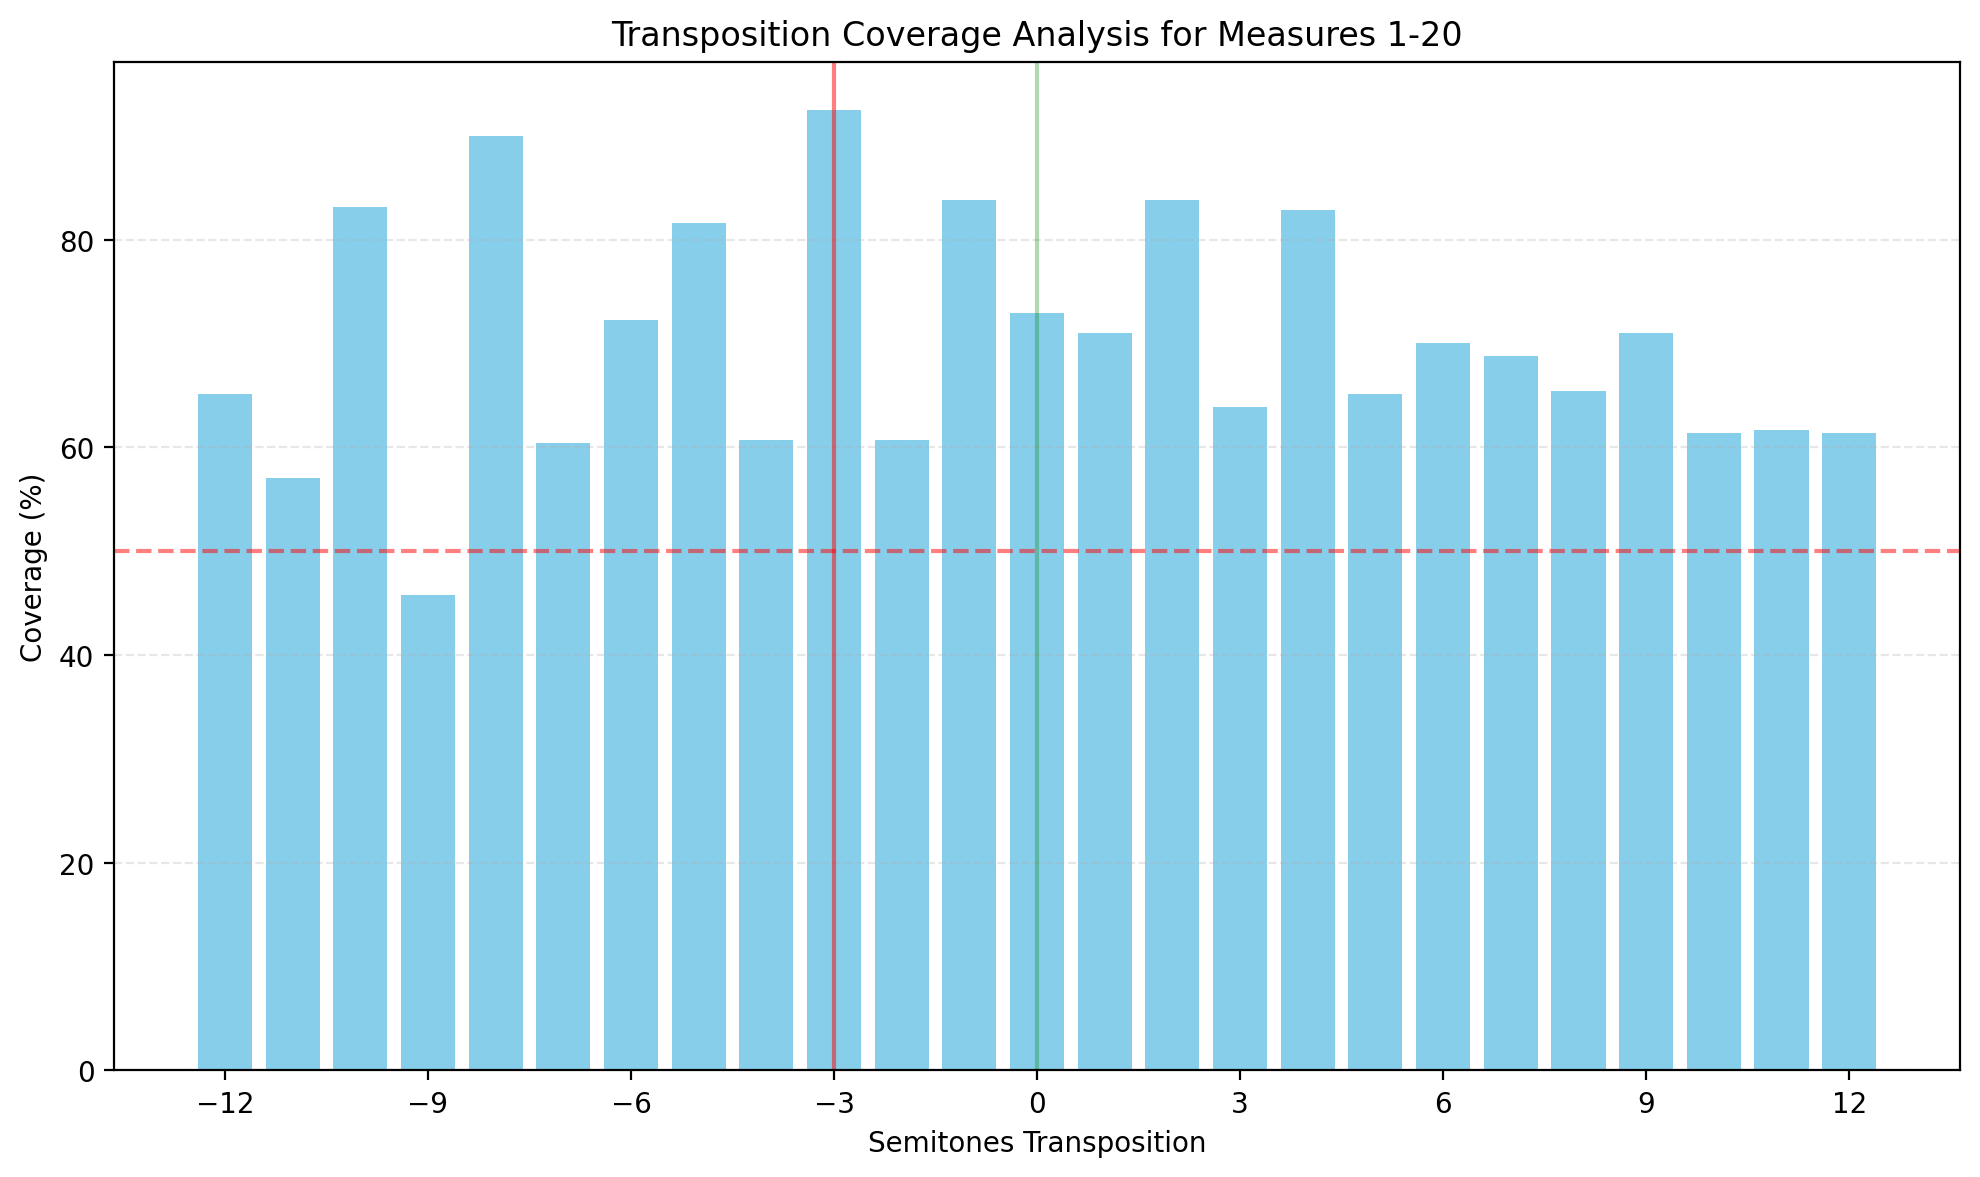


Transposition Analysis for Measures 1-20:
Total unique notes in section: 25
Total notes in section: 321

Top 5 Transposition Strategies:
1. Transpose by -3 semitones: 297/321 notes covered (92.5%)
2. Transpose by -8 semitones: 289/321 notes covered (90.0%)
3. Transpose by -1 semitones: 269/321 notes covered (83.8%)
4. Transpose by +2 semitones: 269/321 notes covered (83.8%)
5. Transpose by -10 semitones: 267/321 notes covered (83.2%)

Recommended transposition: -3 semitones with 92.5% coverage


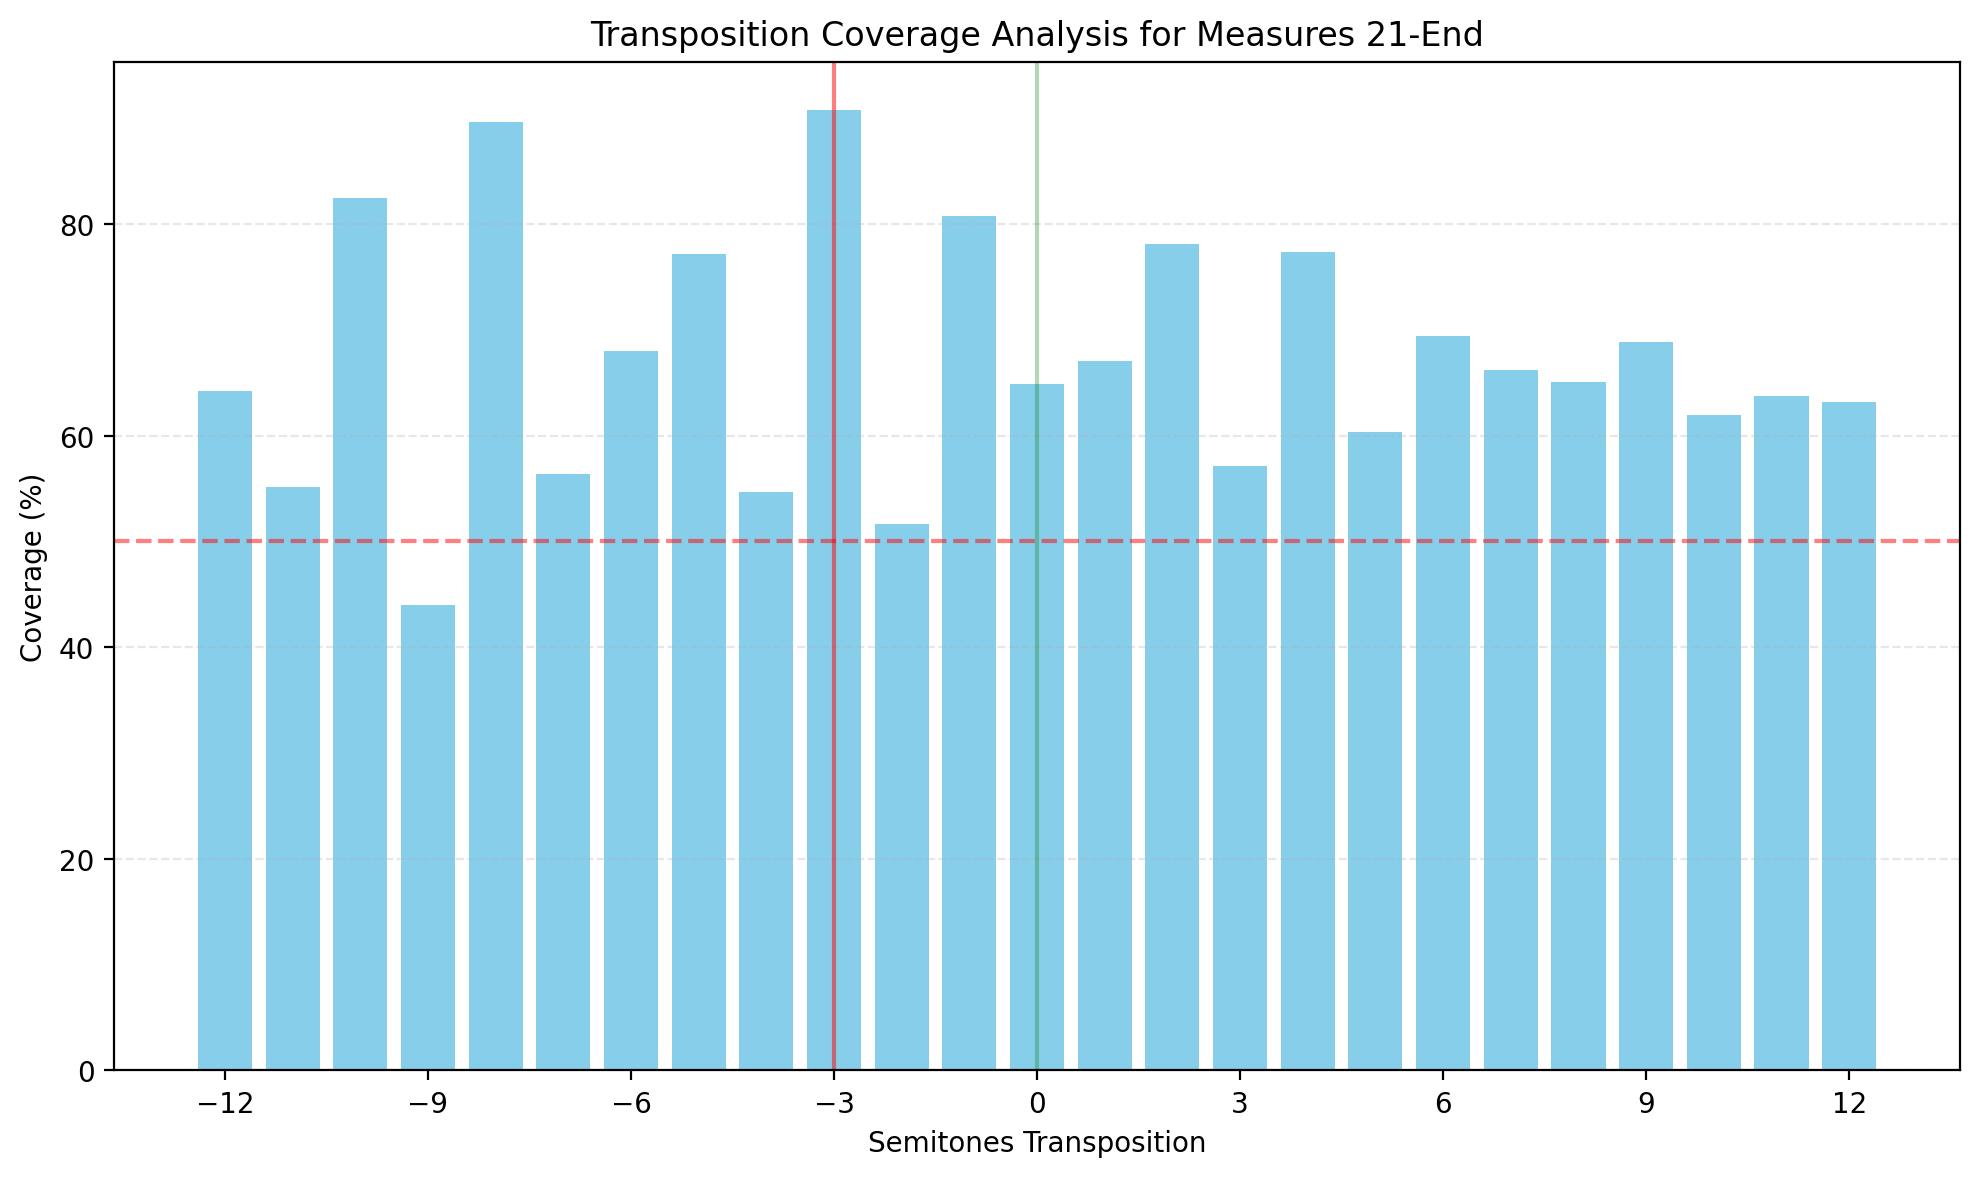


Transposition Analysis for Measures 21-End:
Total unique notes in section: 30
Total notes in section: 1240

Top 5 Transposition Strategies:
1. Transpose by -3 semitones: 1126/1240 notes covered (90.8%)
2. Transpose by -8 semitones: 1112/1240 notes covered (89.7%)
3. Transpose by -10 semitones: 1022/1240 notes covered (82.4%)
4. Transpose by -1 semitones: 1001/1240 notes covered (80.7%)
5. Transpose by +2 semitones: 969/1240 notes covered (78.1%)

Recommended transposition: -3 semitones with 90.8% coverage


In [ ]:
def analyze_transposition_for_section(score, music_box_notes, start_measure=1, end_measure=None):
    """Analyze different transposition strategies for a specific section of music"""
    # Extract notes from the specified section
    section_notes = []
    for part in score.parts:
        for measure in part.getElementsByClass('Measure'):
            if measure.number < start_measure:
                continue
            if end_measure and measure.number > end_measure:
                break
                
            for note_obj in measure.notesAndRests:
                if note_obj.isNote:
                    section_notes.append(note_obj.pitch.nameWithOctave)
                elif note_obj.isChord:
                    for chord_note in note_obj.pitches:
                        section_notes.append(chord_note.nameWithOctave)
    
    # Analyze transpositions
    transposition_results = []
    best_semitones = 0
    best_coverage = 0
    
    for semitones in range(-12, 13):
        transposed_notes = []
        for note in section_notes:
            p = pitch.Pitch(note)
            p.transpose(semitones, inPlace=True)
            transposed_note = convert_to_music_box_notation(p.nameWithOctave)
            transposed_notes.append(transposed_note)
        
        # Calculate coverage
        avail_count = sum(1 for note in transposed_notes if note in music_box_notes)
        coverage = avail_count / len(section_notes) if section_notes else 0
        
        transposition_results.append((semitones, coverage, avail_count, len(section_notes)))
        
        if coverage > best_coverage:
            best_coverage = coverage
            best_semitones = semitones
    
    # Sort by coverage
    transposition_results.sort(key=lambda x: x[1], reverse=True)
    
    # Create visualization
    plt.figure(figsize=(10, 6))
    semitones = [r[0] for r in transposition_results]
    coverages = [r[1] * 100 for r in transposition_results]
    
    plt.bar(semitones, coverages, color='skyblue')
    plt.axhline(y=50, color='r', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='green', linestyle='-', alpha=0.3)
    plt.axvline(x=best_semitones, color='red', linestyle='-', alpha=0.5)
    
    plt.title(f'Transposition Coverage Analysis for Measures {start_measure}-{end_measure or "End"}')
    plt.xlabel('Semitones Transposition')
    plt.ylabel('Coverage (%)')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.xticks(range(-12, 13, 3))
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\nTransposition Analysis for Measures {start_measure}-{end_measure or 'End'}:")
    print(f"Total unique notes in section: {len(set(section_notes))}")
    print(f"Total notes in section: {len(section_notes)}")
    print("\nTop 5 Transposition Strategies:")
    
    for i, (semitones, coverage, avail, total) in enumerate(transposition_results[:5]):
        print(f"{i+1}. Transpose by {semitones:+d} semitones: {avail}/{total} notes covered ({coverage*100:.1f}%)")
    
    print(f"\nRecommended transposition: {best_semitones:+d} semitones with {best_coverage*100:.1f}% coverage")
    
    return best_semitones, transposition_results

# Analyze first half of the piece
first_half_best, first_half_results = analyze_transposition_for_section(score, music_box_notes, 1, 20)

# Analyze second half of the piece
second_half_best, second_half_results = analyze_transposition_for_section(score, music_box_notes, 21)

## TASK2: ANALYZE TRANSPOSITION BY SECTION NEW

In [ ]:
def divide_score_into_parts(score, num_parts):
    """Divide the score into a specified number of equal parts"""
    parts = []
    
    # Get all measures
    all_measures = []
    for part in score.parts:
        all_measures.extend([(part_idx, measure) for part_idx, measure in enumerate(part.getElementsByClass('Measure'))])
    
    # Sort by measure number
    all_measures.sort(key=lambda x: x[1].number if hasattr(x[1], 'number') else 0)
    
    # Calculate measures per part
    total_measures = len(all_measures)
    measures_per_part = total_measures // num_parts
    remainder = total_measures % num_parts
    
    # Divide into parts
    current_index = 0
    for i in range(num_parts):
        part_size = measures_per_part + (1 if i < remainder else 0)
        part_measures = all_measures[current_index:current_index + part_size]
        parts.append(part_measures)
        current_index += part_size
    
    return parts


def extract_part_to_mxl(score, part_measures, semitones, output_path):
    """Extract a part to a new MXL file with the specified transposition"""
    from music21 import stream, note, chord
    import copy
    import os
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Create a new score
    new_score = stream.Score()
    
    # Copy metadata if available
    if hasattr(score, 'metadata') and score.metadata is not None:
        new_score.metadata = copy.deepcopy(score.metadata)
    
    # Create a new part
    new_part = stream.Part()
    
    # Add measures from the part
    for part_idx, measure in part_measures:
        # Create a deep copy of the measure
        measure_copy = copy.deepcopy(measure)
        
        # Transpose all notes and chords in the measure
        for elem in measure_copy.recurse():
            if isinstance(elem, note.Note):
                elem.pitch.transpose(semitones, inPlace=True)
            elif isinstance(elem, chord.Chord):
                for pitch_obj in elem.pitches:
                    pitch_obj.transpose(semitones, inPlace=True)
        
        new_part.append(measure_copy)
    
    new_score.append(new_part)
    
    # Write to file
    new_score.write('musicxml', fp=output_path)
    return new_score

def analyze_parts_transposition(score, num_parts, music_box_notes):
    """Analyze transposition strategies for different parts of the score"""
    import matplotlib.pyplot as plt
    
    # Divide score into parts
    parts = divide_score_into_parts(score, num_parts)
    
    # Analyze each part
    results = []
    
    for i, part_measures in enumerate(parts):
        best_transposition, transposition_results = analyze_part_transposition(score, part_measures, music_box_notes)
        
        # Print results
        part_number = i + 1
        semitones, coverage, avail, total = best_transposition
        
        print(f"\nPart {part_number}:")
        print(f"Best transposition: {semitones:+d} semitones")
        print(f"Coverage: {avail}/{total} notes ({coverage*100:.1f}%)")
        
        # Create visualization
        plt.figure(figsize=(10, 6))
        all_semitones = [r[0] for r in transposition_results]
        all_coverages = [r[1] * 100 for r in transposition_results]
        
        plt.bar(all_semitones, all_coverages, color='skyblue')
        plt.axhline(y=50, color='r', linestyle='--', alpha=0.5)
        plt.axvline(x=0, color='green', linestyle='-', alpha=0.3)
        plt.axvline(x=semitones, color='red', linestyle='-', alpha=0.5)
        
        plt.title(f'Transposition Coverage for Part {part_number}')
        plt.xlabel('Semitones Transposition')
        plt.ylabel('Coverage (%)')
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        plt.xticks(range(-12, 13, 3))
        plt.tight_layout()
        plt.show()
        
        # Extract part to MXL
        output_path = f"/workspaces/codespaces-jupyter/music/divided_parts/part_{part_number}_transposed_{semitones:+d}.mxl"
        try:
            extract_part_to_mxl(score, part_measures, semitones, output_path)
            print(f"Saved part {part_number} transposed by {semitones:+d} semitones to {output_path}")
        except Exception as e:
            print(f"Error saving part {part_number}: {str(e)}")
        
        results.append((part_number, semitones, coverage))
    
    return results

# Analyze with different numbers of parts
print("\nAnalyzing transposition strategies for 3 parts...")
part_results = analyze_parts_transposition(score, 3, music_box_notes)


Analyzing transposition strategies for 3 parts...


TypeError: unsupported operand type(s) for //: 'int' and 'list'


Creating music box adapted score...

Adapted Score Summary:
Total notes: 1561
Directly playable notes: 1423 (91.2%)
Adapted notes: 121 (7.8%)
Unplayable notes: 17 (1.1%)

Note Adjustments (first 10):
F2 → G2 (distance: 2 semitones)
E2 → D2 (distance: 2 semitones)
F5 → E5 (distance: 1 semitones)
F5 → E5 (distance: 1 semitones)
F2 → G2 (distance: 2 semitones)
F5 → E5 (distance: 1 semitones)
F5 → E5 (distance: 1 semitones)
F5 → E5 (distance: 1 semitones)
F5 → E5 (distance: 1 semitones)
F5 → E5 (distance: 1 semitones)


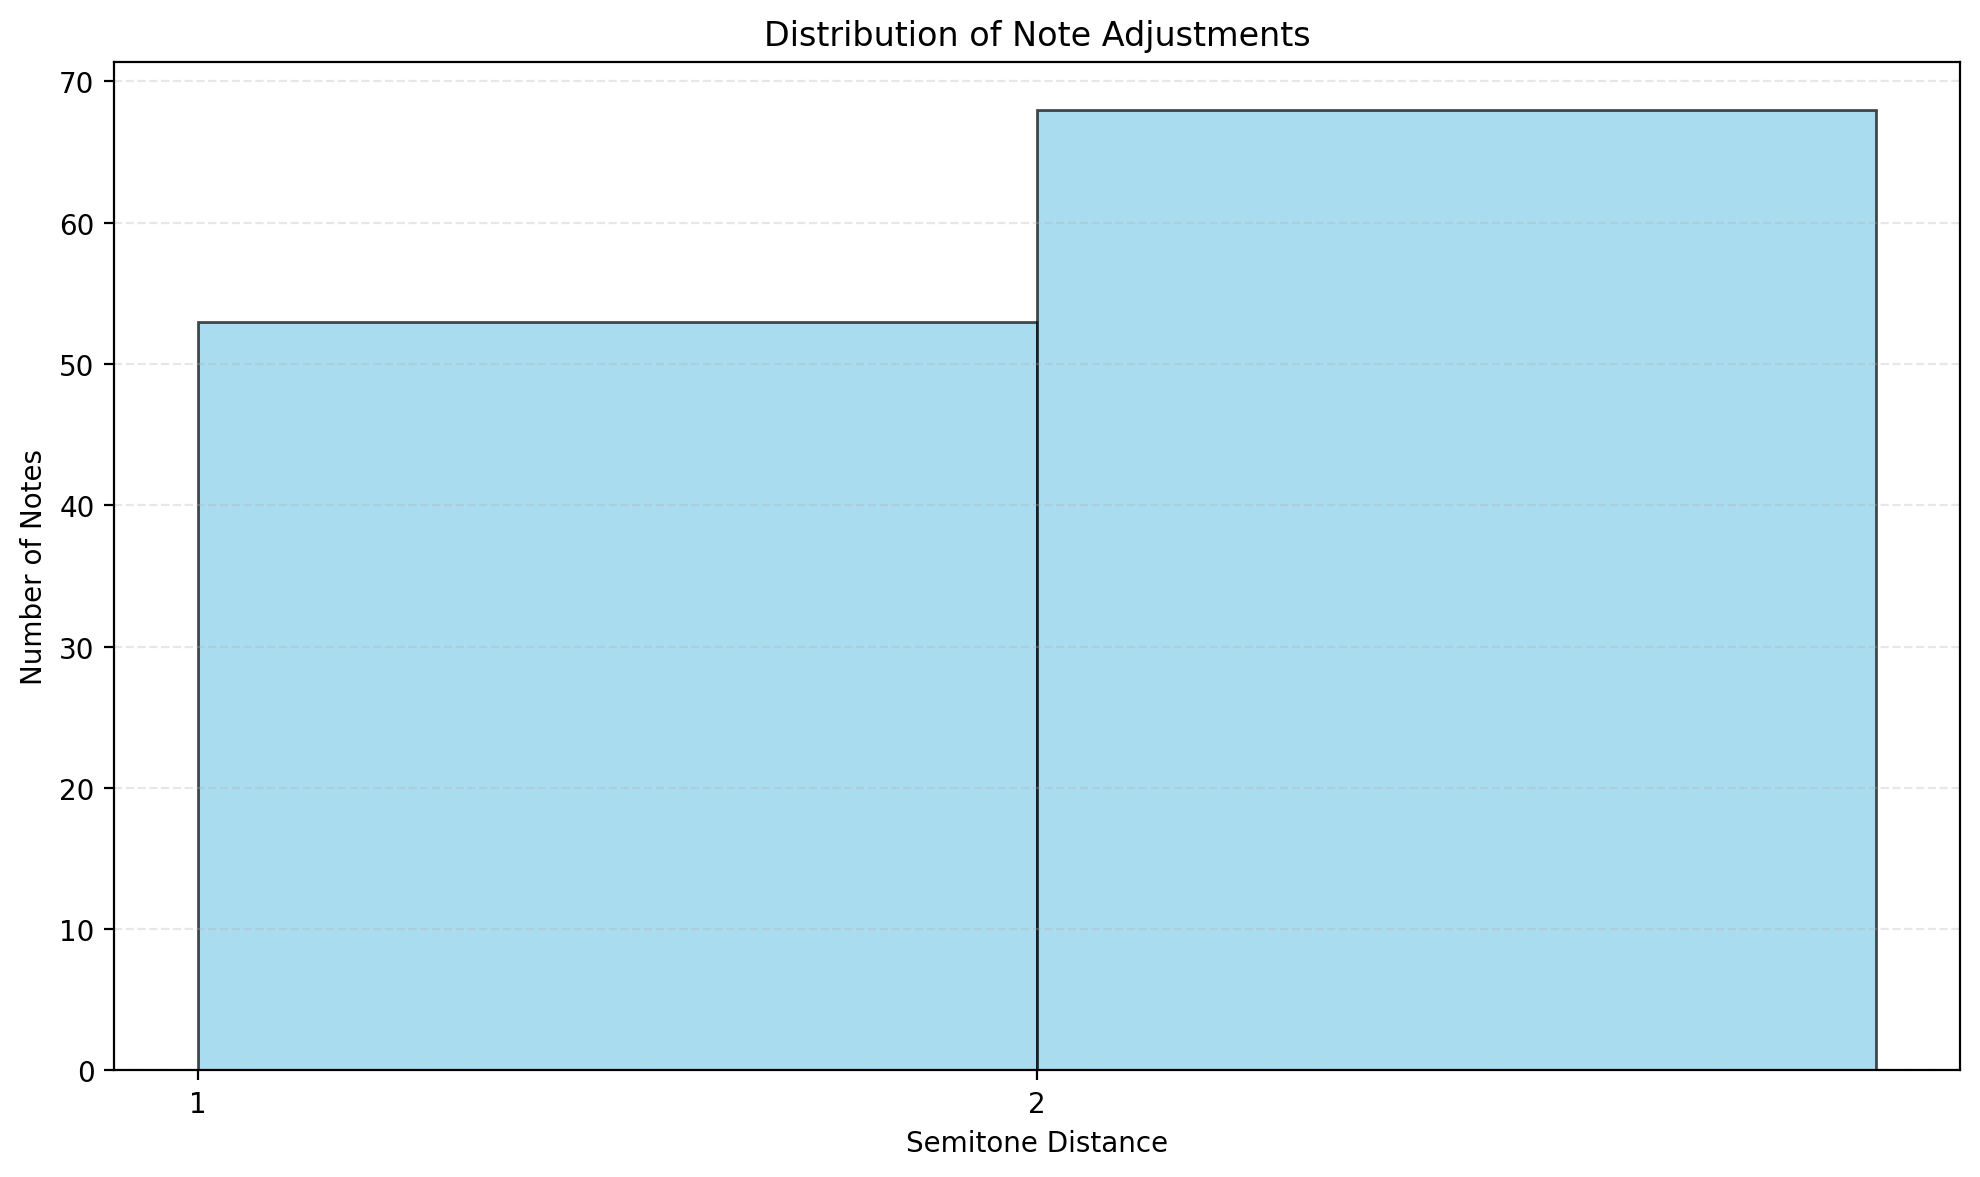

In [ ]:
def find_closest_available_note(target_note, music_box_notes, max_distance=2):
    """Find the closest available note in the music box"""
    # Convert all music box notes to music21 pitches for comparison
    music_box_pitches = []
    for mbx_note in music_box_notes:
        # Adjust music box notation back to music21 notation
        if mbx_note.isalpha() or (len(mbx_note) > 1 and mbx_note[-1] == '#'):
            # Note with no octave or just with sharp
            adj_note = mbx_note + '2'  # Add octave 2
        else:
            # Note with octave number
            note_part = ''.join([c for c in mbx_note if c.isalpha() or c == '#'])
            octave_part = ''.join([c for c in mbx_note if c.isdigit()])
            adj_note = note_part + str(int(octave_part) + 2)  # Adjust octave
            
        music_box_pitches.append((mbx_note, pitch.Pitch(adj_note)))
    
    # Get the target pitch
    target_pitch = pitch.Pitch(target_note)
    
    # Find the closest match
    best_distance = float('inf')
    best_match = None
    
    for mbx_note, mbx_pitch in music_box_pitches:
        distance = abs(mbx_pitch.midi - target_pitch.midi)
        
        if distance < best_distance:
            best_distance = distance
            best_match = mbx_note
    
    # Return the closest note if within max_distance
    if best_distance <= max_distance:
        return best_match, best_distance
    else:
        return None, best_distance

def create_adapted_score(score, semitones, music_box_notes, output_path):
    """Create a fully adapted version using the best transposition strategy"""
    from music21 import stream, note, chord, expressions, pitch
    import copy
    import os
    
    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Create a deep copy of the score
    adapted_score = copy.deepcopy(score)
    
    # Track adjustments
    adjustments = []
    total_notes = 0
    direct_matches = 0
    adapted_notes = 0
    
    # Process all notes
    for part in adapted_score.parts:
        # First transpose all notes by the target semitones
        for element in part.recurse():
            if isinstance(element, note.Note):
                element.pitch.transpose(semitones, inPlace=True)
            elif isinstance(element, chord.Chord):
                for pitch_obj in element.pitches:
                    pitch_obj.transpose(semitones, inPlace=True)
        
        # Then adapt non-matching notes to available music box notes
        for element in part.recurse():
            if isinstance(element, note.Note):
                total_notes += 1
                
                # Check if the transposed note is available
                music_box_note = convert_to_music_box_notation(element.pitch.nameWithOctave)
                
                if music_box_note in music_box_notes:
                    direct_matches += 1
                else:
                    # Find the closest available note
                    closest_note, distance = find_closest_available_note(
                        element.pitch.nameWithOctave, music_box_notes)
                    
                    if closest_note:
                        adapted_notes += 1
                        
                        # Convert back to music21 notation
                        if closest_note.isalpha() or (len(closest_note) > 1 and closest_note[-1] == '#'):
                            adj_note = closest_note + '2'
                        else:
                            note_part = ''.join([c for c in closest_note if c.isalpha() or c == '#'])
                            octave_part = ''.join([c for c in closest_note if c.isdigit()])
                            adj_note = note_part + str(int(octave_part) + 2)
                        
                        # Save original pitch for tracking
                        original_pitch = copy.deepcopy(element.pitch)
                        
                        # Set new pitch
                        element.pitch = pitch.Pitch(adj_note)
                        
                        # Add an expression to mark the adjustment
                        element.expressions.append(expressions.TextExpression('*'))
                        
                        # Track the adjustment
                        adjustments.append((original_pitch.nameWithOctave, 
                                          element.pitch.nameWithOctave,
                                          distance))
            
            elif isinstance(element, chord.Chord):
                # For each pitch in the chord
                new_pitches = []
                chord_adjusted = False
                
                for i, p in enumerate(element.pitches):
                    total_notes += 1
                    
                    # Check if the transposed note is available
                    music_box_note = convert_to_music_box_notation(p.nameWithOctave)
                    
                    if music_box_note in music_box_notes:
                        direct_matches += 1
                        new_pitches.append(p)
                    else:
                        # Find the closest available note
                        closest_note, distance = find_closest_available_note(
                            p.nameWithOctave, music_box_notes)
                        
                        if closest_note:
                            adapted_notes += 1
                            chord_adjusted = True
                            
                            # Convert back to music21 notation
                            if closest_note.isalpha() or (len(closest_note) > 1 and closest_note[-1] == '#'):
                                adj_note = closest_note + '2'
                            else:
                                note_part = ''.join([c for c in closest_note if c.isalpha() or c == '#'])
                                octave_part = ''.join([c for c in closest_note if c.isdigit()])
                                adj_note = note_part + str(int(octave_part) + 2)
                            
                            # Create the new pitch
                            new_pitch = pitch.Pitch(adj_note)
                            new_pitches.append(new_pitch)
                            
                            # Track the adjustment
                            adjustments.append((p.nameWithOctave, 
                                              new_pitch.nameWithOctave,
                                              distance))
                        else:
                            # If no close match, keep the original pitch
                            new_pitches.append(p)
                
                # Update the chord with new pitches
                if chord_adjusted:
                    if new_pitches:  # Only if we have pitches
                        element.pitches = new_pitches
                        
                        # Add an expression to mark the adjustment
                        if not element.expressions:
                            element.expressions = []
                        element.expressions.append(expressions.TextExpression('*'))
    
    # Update metadata
    if hasattr(adapted_score, 'metadata') and adapted_score.metadata is not None:
        if hasattr(adapted_score.metadata, 'title') and adapted_score.metadata.title:
            adapted_score.metadata.title = f"{adapted_score.metadata.title} (Music Box Adaptation)"
        
        if hasattr(adapted_score.metadata, 'composer') and adapted_score.metadata.composer:
            adapted_score.metadata.composer += f" (Arr. for 30-note Music Box, {semitones:+d} semitones)"
    
    # Make sure duration information is valid before writing to file
    for part in adapted_score.parts:
        for measure in part.getElementsByClass('Measure'):
            # Ensure all notes/rests have valid durations
            for element in measure.notesAndRests:
                if element.duration.type is None and element.duration.quarterLength > 0:
                    # Fix the duration type if it's missing
                    element.duration.quarterLength = element.duration.quarterLength
    
    # Write to file - use a try-except to catch and handle any issues
    try:
        adapted_score.write('musicxml', fp=output_path)
    except Exception as e:
        print(f"Error saving MusicXML: {str(e)}")
        print("Trying to fix duration issues...")
        
        # Alternative approach: recreate the score from scratch with valid durations
        from music21 import metadata
        
        fixed_score = stream.Score()
        
        # Copy metadata
        if hasattr(adapted_score, 'metadata') and adapted_score.metadata:
            fixed_score.metadata = metadata.Metadata()
            if hasattr(adapted_score.metadata, 'title'):
                fixed_score.metadata.title = adapted_score.metadata.title
            if hasattr(adapted_score.metadata, 'composer'):
                fixed_score.metadata.composer = adapted_score.metadata.composer
        
        # Copy each part
        for part_idx, part in enumerate(adapted_score.parts):
            fixed_part = stream.Part(id=part.id)
            
            # Copy measures
            for measure in part.getElementsByClass('Measure'):
                fixed_measure = stream.Measure(number=measure.number)
                
                # Copy clef, key, time signature
                for element in measure.getElementsByClass(['Clef', 'KeySignature', 'TimeSignature']):
                    fixed_measure.append(copy.deepcopy(element))
                
                # Copy notes and rests with fixed durations
                for element in measure.notesAndRests:
                    if isinstance(element, note.Note):
                        new_note = note.Note(element.pitch)
                        new_note.duration = copy.deepcopy(element.duration)
                        new_note.expressions = element.expressions
                        fixed_measure.append(new_note)
                    elif isinstance(element, chord.Chord):
                        new_chord = chord.Chord(element.pitches)
                        new_chord.duration = copy.deepcopy(element.duration)
                        new_chord.expressions = element.expressions
                        fixed_measure.append(new_chord)
                    else:  # Rest
                        new_rest = note.Rest()
                        new_rest.duration = copy.deepcopy(element.duration)
                        fixed_measure.append(new_rest)
                
                fixed_part.append(fixed_measure)
            
            fixed_score.append(fixed_part)
        
        # Try to save the fixed score
        try:
            fixed_score.write('musicxml', fp=output_path)
            print(f"Successfully saved fixed score to {output_path}")
        except Exception as e:
            print(f"Still unable to save MusicXML: {str(e)}")
            # As a last resort, save in a different format
            alt_path = output_path.replace('.mxl', '.mid')
            fixed_score.write('midi', fp=alt_path)
            print(f"Saved as MIDI instead: {alt_path}")
    
    # Print summary
    print("\nAdapted Score Summary:")
    print(f"Total notes: {total_notes}")
    print(f"Directly playable notes: {direct_matches} ({direct_matches/total_notes*100:.1f}%)")
    print(f"Adapted notes: {adapted_notes} ({adapted_notes/total_notes*100:.1f}%)")
    print(f"Unplayable notes: {total_notes - direct_matches - adapted_notes} ({(total_notes - direct_matches - adapted_notes)/total_notes*100:.1f}%)")
    
    # Print adjustments details (limited to 10 for brevity)
    if adjustments:
        print("\nNote Adjustments (first 10):")
        for i, (original, adjusted, distance) in enumerate(adjustments[:10]):
            print(f"{original} → {adjusted} (distance: {distance} semitones)")
    
    return adapted_score, adjustments

# Create the adapted score using the best transposition (-3 semitones)
print("\nCreating music box adapted score...")
output_path = "/workspaces/codespaces-jupyter/music/music_box_adapted.mxl"
adapted_score, adjustments = create_adapted_score(score, -3, music_box_notes, output_path)

# Visualize adjustments
if adjustments:
    plt.figure(figsize=(10, 6))
    distances = [adj[2] for adj in adjustments]
    
    plt.hist(distances, bins=range(min(distances), max(distances) + 2), 
             color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Note Adjustments')
    plt.xlabel('Semitone Distance')
    plt.ylabel('Number of Notes')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.xticks(range(min(distances), max(distances) + 1))
    plt.tight_layout()
    plt.show()


Creating music box adaptation with -8 semitones and octave shifting...
Standard notation music box notes:
C2, D2, G2, A2, B2, C3, D3, E3, F3, F#3, G3, G#3, A3, A#3, B3, C4, C#4, D4, D#4, E4, F4, F#4, G4, G#4, A4, A#4, B4, C5, D5, E5
Successfully saved to /workspaces/codespaces-jupyter/music/music_box_adapted_oct_shift.mxl

Octave-Shift Adaptation Summary:
Total notes processed: 1561
Direct matches: 1343 (86.0%)
Octave-shifted notes: 208 (13.3%)
Unmatchable notes: 10 (0.6%)


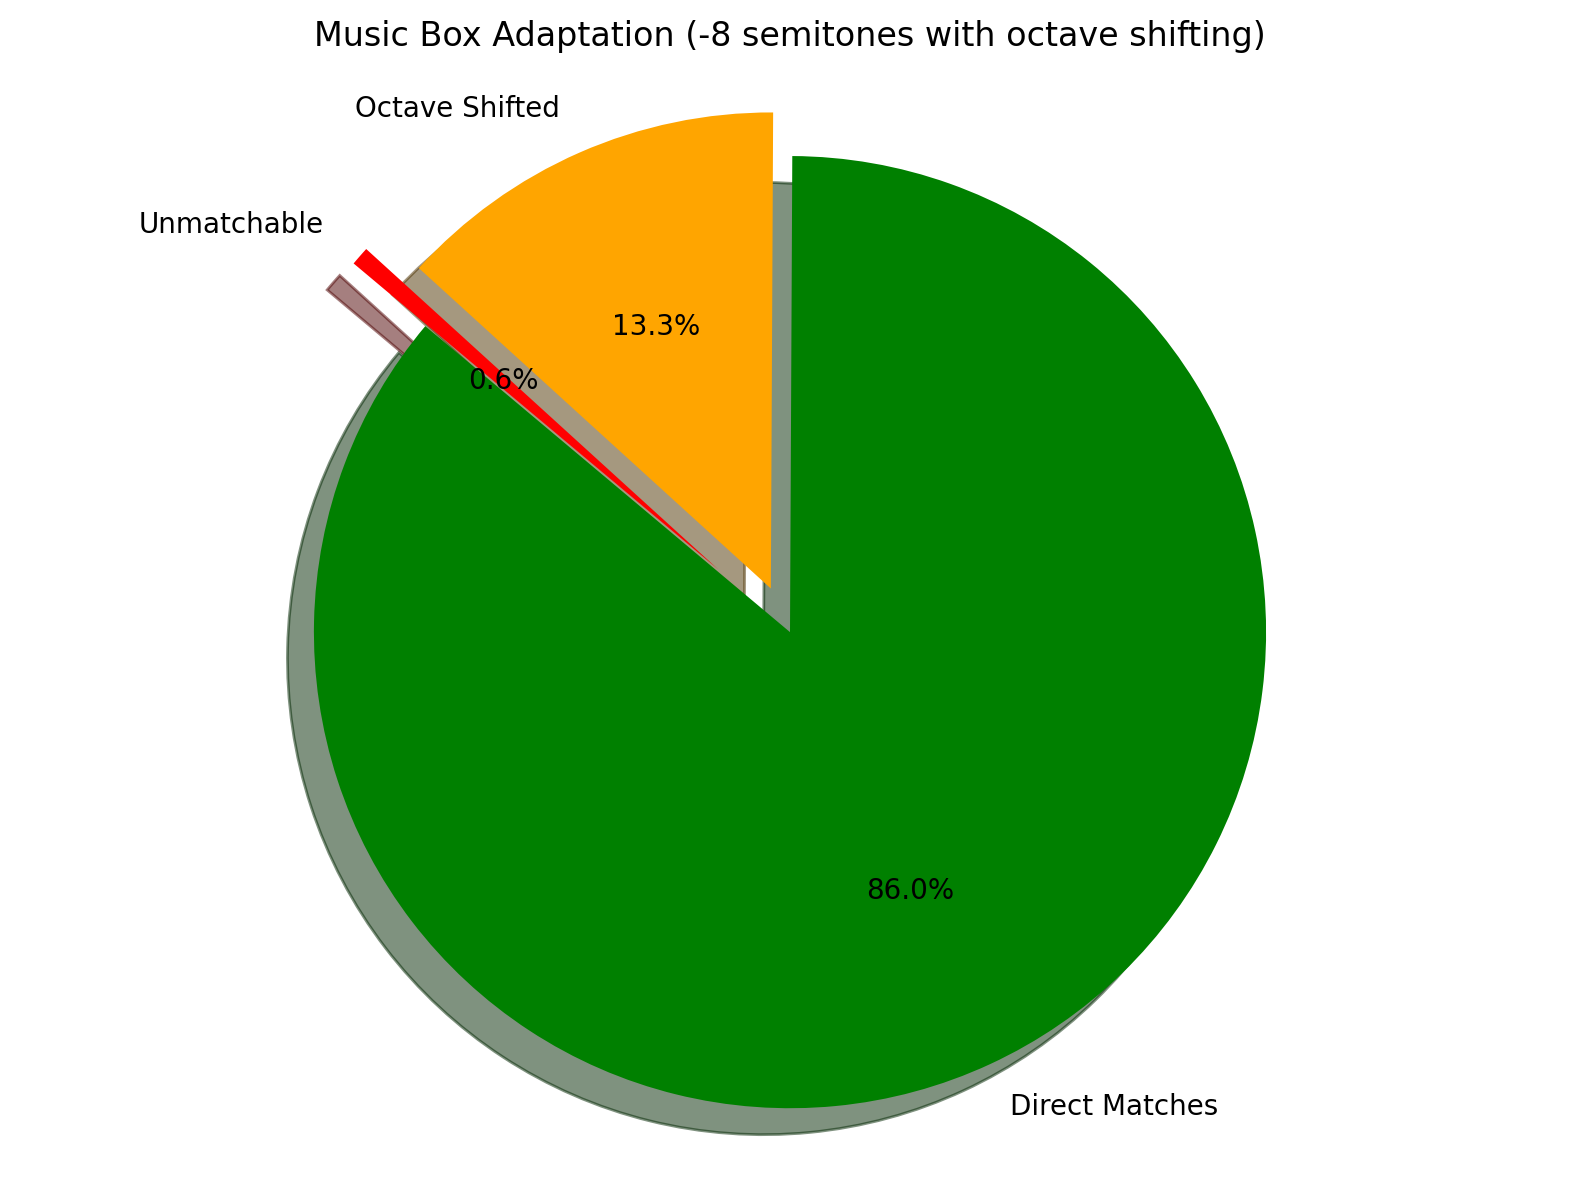

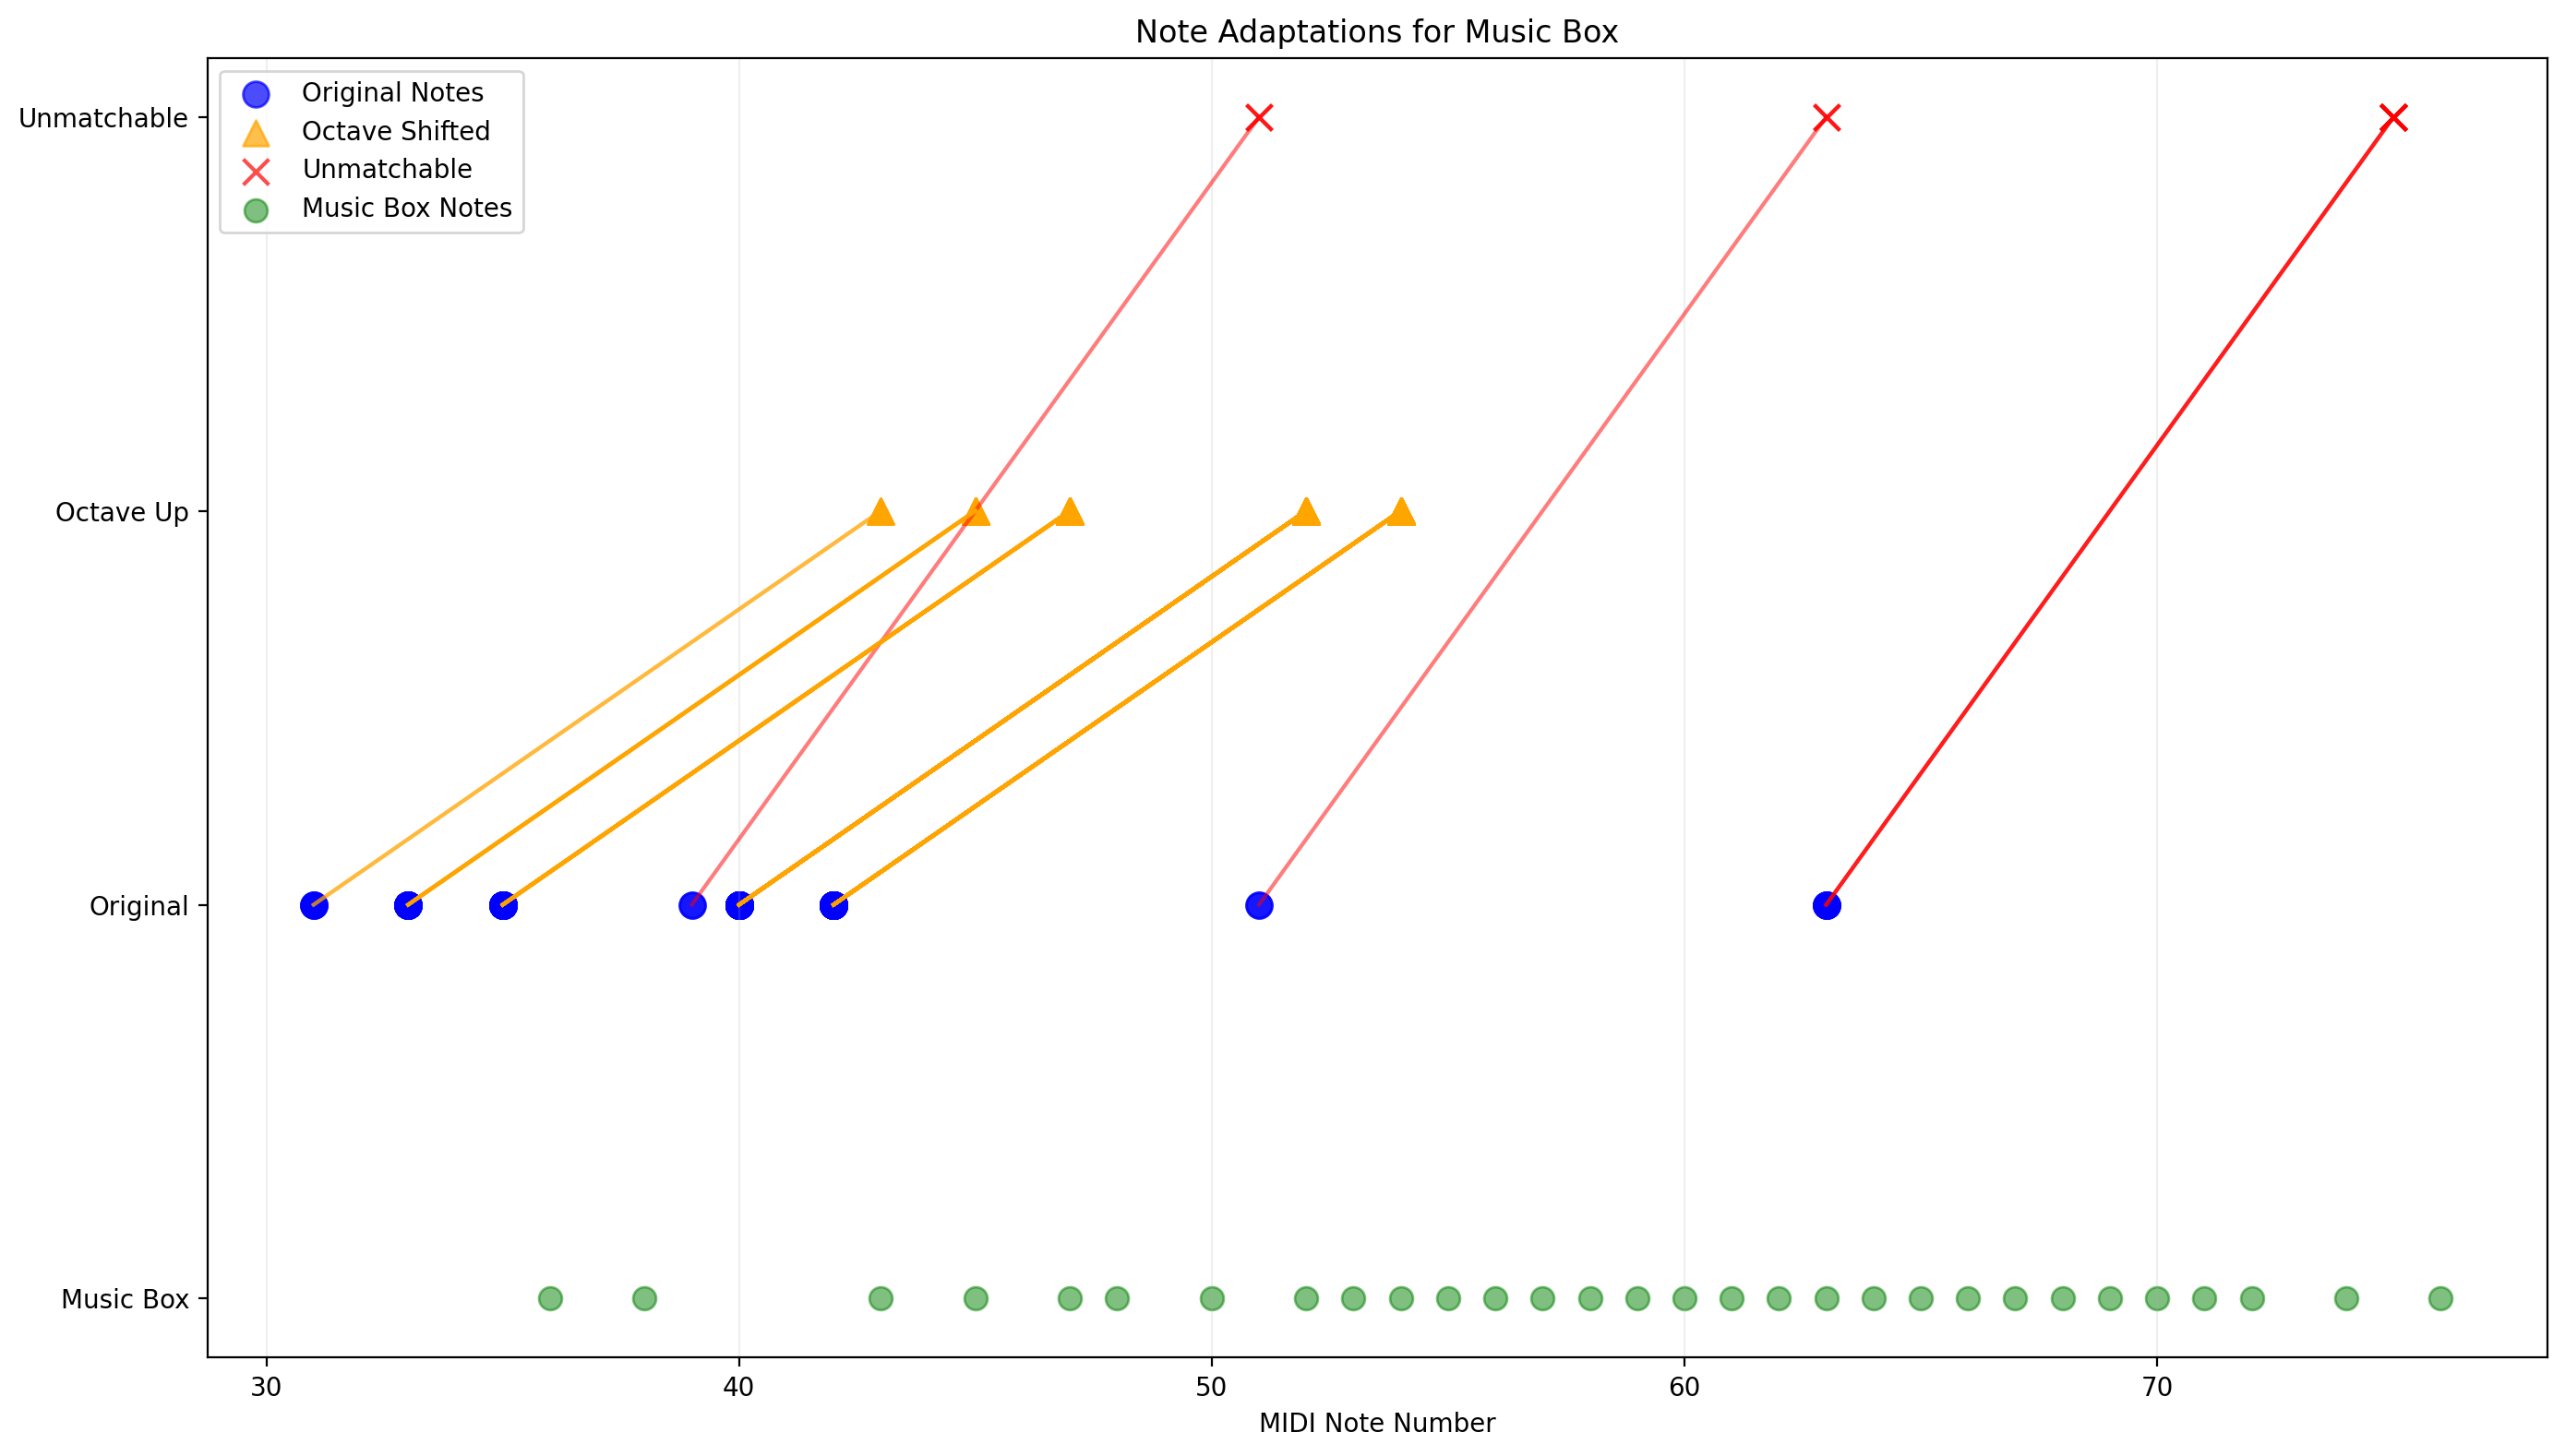

In [83]:
def create_octave_shifted_adaptation(score, transpose_semitones, music_box_notes, output_path):
    """
    Create a music box adaptation with the following rules:
    1. Transpose the entire song by specified semitones
    2. For any unmatched notes, move them up one octave
    3. No tolerance - notes must match exactly
    """
    from music21 import stream, note, chord, expressions, pitch
    import copy
    import os
    
    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Convert music box notes to standard notation (adding 2 octaves)
    standard_music_box_notes = []
    for mbx_note in music_box_notes:
        # Parse the note and add 2 octaves
        if mbx_note.isalpha() or (len(mbx_note) > 1 and mbx_note[-1] == '#'):
            # Note with no octave or just with sharp - add octave 2
            adj_note = mbx_note + '2'
        else:
            # Note with octave number
            note_part = ''.join([c for c in mbx_note if c.isalpha() or c == '#'])
            octave_part = int(''.join([c for c in mbx_note if c.isdigit()]))
            adj_note = note_part + str(octave_part + 2)  # Add 2 octaves
            
        standard_music_box_notes.append(adj_note)
    
    # Print the adjusted music box notes for verification
    print("Standard notation music box notes:")
    print(", ".join(standard_music_box_notes))
    
    # Create a deep copy of the score
    adapted_score = copy.deepcopy(score)
    
    # Track adaptations
    adaptations = {
        'direct_matches': 0,
        'octave_shifted': 0, 
        'unmatchable': 0,
        'total': 0
    }
    adjustment_details = []
    
    # Process all notes in the score
    for part in adapted_score.parts:
        # First transpose all notes by the target semitones
        for element in part.recurse():
            if isinstance(element, note.Note):
                element.pitch.transpose(transpose_semitones, inPlace=True)
            elif isinstance(element, chord.Chord):
                for pitch_obj in element.pitches:
                    pitch_obj.transpose(transpose_semitones, inPlace=True)
        
        # Then process unmatched notes
        for element in part.recurse():
            if isinstance(element, note.Note):
                adaptations['total'] += 1
                
                # Check if transposed note is directly available
                original_name = element.pitch.nameWithOctave
                
                if original_name in standard_music_box_notes:
                    adaptations['direct_matches'] += 1
                else:
                    # Try shifting up one octave
                    original_note = element.pitch.nameWithOctave
                    element.pitch.transpose(12, inPlace=True)  # Up one octave
                    
                    if element.pitch.nameWithOctave in standard_music_box_notes:
                        adaptations['octave_shifted'] += 1
                        element.expressions.append(expressions.TextExpression('↑'))  # Mark with up arrow
                        adjustment_details.append((original_note, element.pitch.nameWithOctave, 'octave_up'))
                    else:
                        adaptations['unmatchable'] += 1
                        element.expressions.append(expressions.TextExpression('✗'))  # Mark unmatchable notes
                        adjustment_details.append((original_note, element.pitch.nameWithOctave, 'unmatchable'))
            
            elif isinstance(element, chord.Chord):
                # For chords, we need to collect all pitches first, then modify the entire collection
                new_pitches = []
                chord_adjusted = False
                
                for i, p in enumerate(element.pitches):
                    adaptations['total'] += 1
                    original_note = p.nameWithOctave
                    pitch_copy = copy.deepcopy(p)
                    
                    # Check direct match
                    if original_note in standard_music_box_notes:
                        adaptations['direct_matches'] += 1
                        new_pitches.append(pitch_copy)
                    else:
                        # Try octave shift
                        pitch_copy.transpose(12, inPlace=True)  # Up one octave
                        
                        if pitch_copy.nameWithOctave in standard_music_box_notes:
                            adaptations['octave_shifted'] += 1
                            new_pitches.append(pitch_copy)
                            chord_adjusted = True
                            adjustment_details.append((original_note, pitch_copy.nameWithOctave, 'octave_up'))
                        else:
                            adaptations['unmatchable'] += 1
                            new_pitches.append(pitch_copy)  # Keep the octave-shifted version anyway
                            chord_adjusted = True
                            adjustment_details.append((original_note, pitch_copy.nameWithOctave, 'unmatchable'))
                
                # Update chord with new pitches
                element.pitches = tuple(new_pitches)
                
                # Mark the chord if it has modifications
                if chord_adjusted:
                    if not element.expressions:
                        element.expressions = []
                    
                    # Mark with the appropriate symbols
                    if any(adj[2] == 'unmatchable' for adj in adjustment_details[-len(element.pitches):]):
                        element.expressions.append(expressions.TextExpression('✗'))
                    else:
                        element.expressions.append(expressions.TextExpression('↑'))
    
    # Update metadata
    if hasattr(adapted_score, 'metadata') and adapted_score.metadata is not None:
        if hasattr(adapted_score.metadata, 'title') and adapted_score.metadata.title:
            adapted_score.metadata.title = f"{adapted_score.metadata.title} (Music Box -8 Oct+)"
        
        if hasattr(adapted_score.metadata, 'composer') and adapted_score.metadata.composer:
            adapted_score.metadata.composer += f" (Arr. for 30-note Music Box, {transpose_semitones} semi + oct shift)"
    
    # Save to file
    try:
        adapted_score.write('musicxml', fp=output_path)
        print(f"Successfully saved to {output_path}")
    except Exception as e:
        print(f"Error saving file: {str(e)}")
        alt_path = output_path.replace('.mxl', '.mid')
        adapted_score.write('midi', fp=alt_path)
        print(f"Saved as MIDI instead: {alt_path}")
    
    # Print adaptation summary
    print("\nOctave-Shift Adaptation Summary:")
    print(f"Total notes processed: {adaptations['total']}")
    print(f"Direct matches: {adaptations['direct_matches']} ({adaptations['direct_matches']/adaptations['total']*100:.1f}%)")
    print(f"Octave-shifted notes: {adaptations['octave_shifted']} ({adaptations['octave_shifted']/adaptations['total']*100:.1f}%)")
    print(f"Unmatchable notes: {adaptations['unmatchable']} ({adaptations['unmatchable']/adaptations['total']*100:.1f}%)")
    
    # Visualize adaptations
    import matplotlib.pyplot as plt
    
    # Create pie chart of adaptations
    plt.figure(figsize=(8, 6))
    labels = ['Direct Matches', 'Octave Shifted', 'Unmatchable']
    sizes = [adaptations['direct_matches'], adaptations['octave_shifted'], adaptations['unmatchable']]
    colors = ['green', 'orange', 'red']
    explode = (0, 0.1, 0.2)  # explode the unmatchable slice
    
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
    plt.title(f'Music Box Adaptation (-8 semitones with octave shifting)')
    plt.tight_layout()
    plt.show()
    
    # Visualize individual note adaptations
    if adjustment_details:
        # Create a visualization of notes that were adjusted
        plt.figure(figsize=(14, 8))
        
        # Convert to midi numbers for plotting
        original_midi = []
        adjusted_midi = []
        adjustment_types = []
        
        for org, adj, adj_type in adjustment_details:
            original_midi.append(pitch.Pitch(org).midi)
            adjusted_midi.append(pitch.Pitch(adj).midi)
            adjustment_types.append(adj_type)
        
        # Plot original notes
        plt.scatter(original_midi, [1] * len(original_midi), 
                   color='blue', s=100, alpha=0.7, label='Original Notes')
        
        # Plot adjusted notes with different colors
        oct_indices = [i for i, t in enumerate(adjustment_types) if t == 'octave_up']
        unm_indices = [i for i, t in enumerate(adjustment_types) if t == 'unmatchable']
        
        if oct_indices:
            plt.scatter([adjusted_midi[i] for i in oct_indices], 
                       [1.3] * len(oct_indices), color='orange', s=100, 
                       alpha=0.7, marker='^', label='Octave Shifted')
        
        if unm_indices:
            plt.scatter([adjusted_midi[i] for i in unm_indices], 
                       [1.6] * len(unm_indices), color='red', s=100, 
                       alpha=0.7, marker='x', label='Unmatchable')
        
        # Add connecting lines
        for i, (org, adj) in enumerate(zip(original_midi, adjusted_midi)):
            color = 'orange' if adjustment_types[i] == 'octave_up' else 'red'
            y_end = 1.3 if adjustment_types[i] == 'octave_up' else 1.6
            plt.plot([org, adj], [1, y_end], color=color, linestyle='-', alpha=0.3)
        
        # Add music box range
        music_box_midi = [pitch.Pitch(n).midi for n in standard_music_box_notes]
        plt.scatter(music_box_midi, [0.7] * len(music_box_midi), 
                   color='green', s=80, alpha=0.5, marker='o', label='Music Box Notes')
        
        plt.yticks([0.7, 1, 1.3, 1.6], ['Music Box', 'Original', 'Octave Up', 'Unmatchable'])
        plt.title('Note Adaptations for Music Box')
        plt.xlabel('MIDI Note Number')
        plt.grid(axis='x', alpha=0.2)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    return adapted_score, adjustment_details, adaptations

# Create the adaptation with -8 semitones and octave shifting
print("\nCreating music box adaptation with -8 semitones and octave shifting...")
output_path = "/workspaces/codespaces-jupyter/music/music_box_adapted_oct_shift.mxl"
adapted_score, adjustment_details, adaptations = create_octave_shifted_adaptation(
    score, -8, music_box_notes, output_path)

In [123]:
print(music_box_notes)

['C', 'D', 'G', 'A', 'B', 'C1', 'D1', 'E1', 'F1', 'F#1', 'G1', 'G#1', 'A1', 'A#1', 'B1', 'C2', 'C#2', 'D2', 'D#2', 'E2', 'F2', 'F#2', 'G2', 'G#2', 'A2', 'A#2', 'B2', 'C3', 'D3', 'E3']



Transposed Score Analysis:
Transposition: -3 semitones
Coverage: 1423/1561 notes (91.2%)


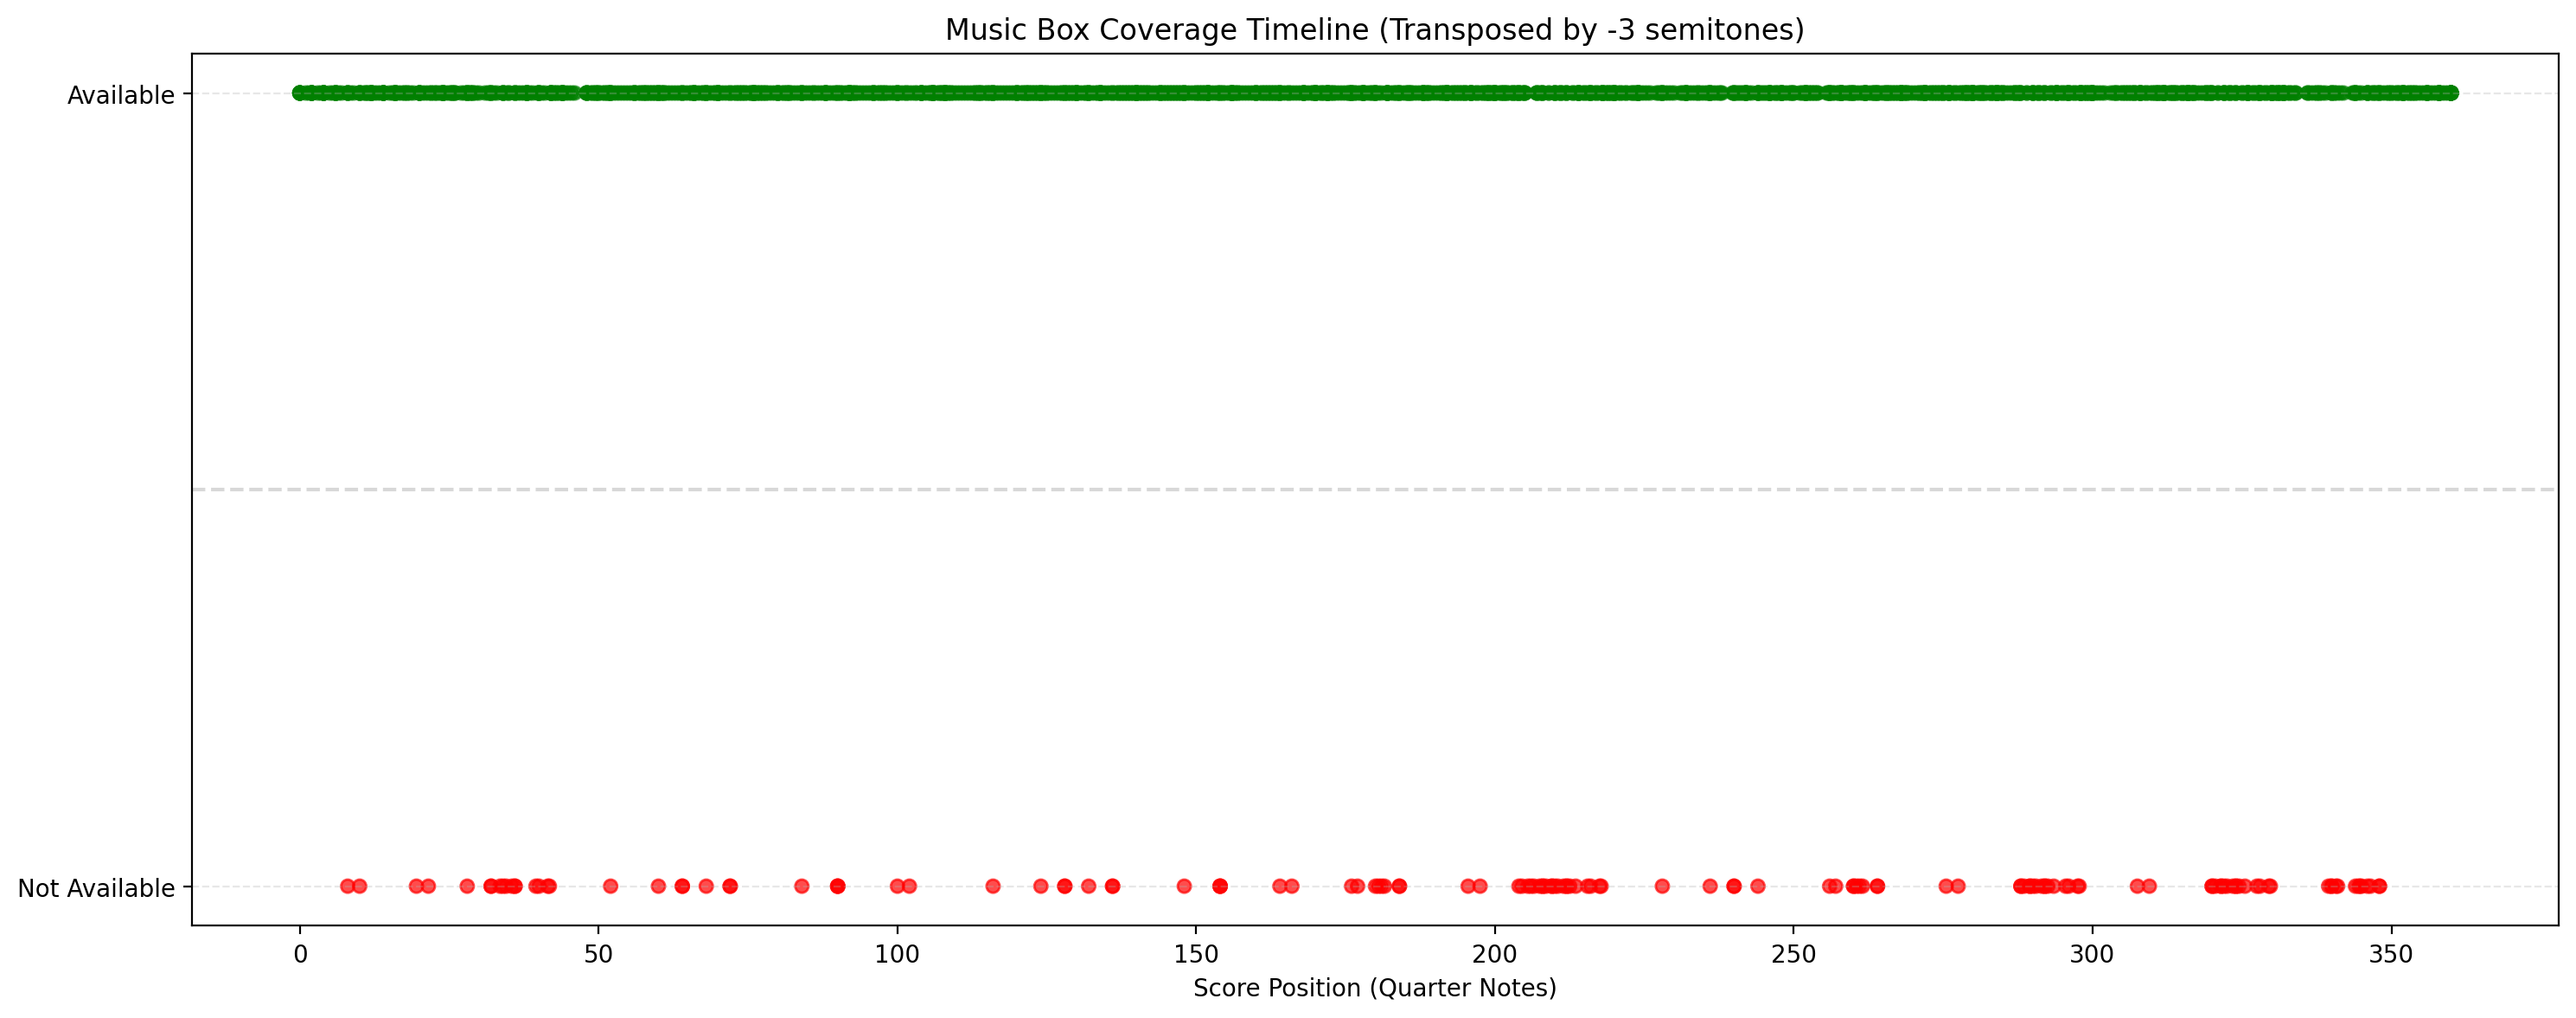

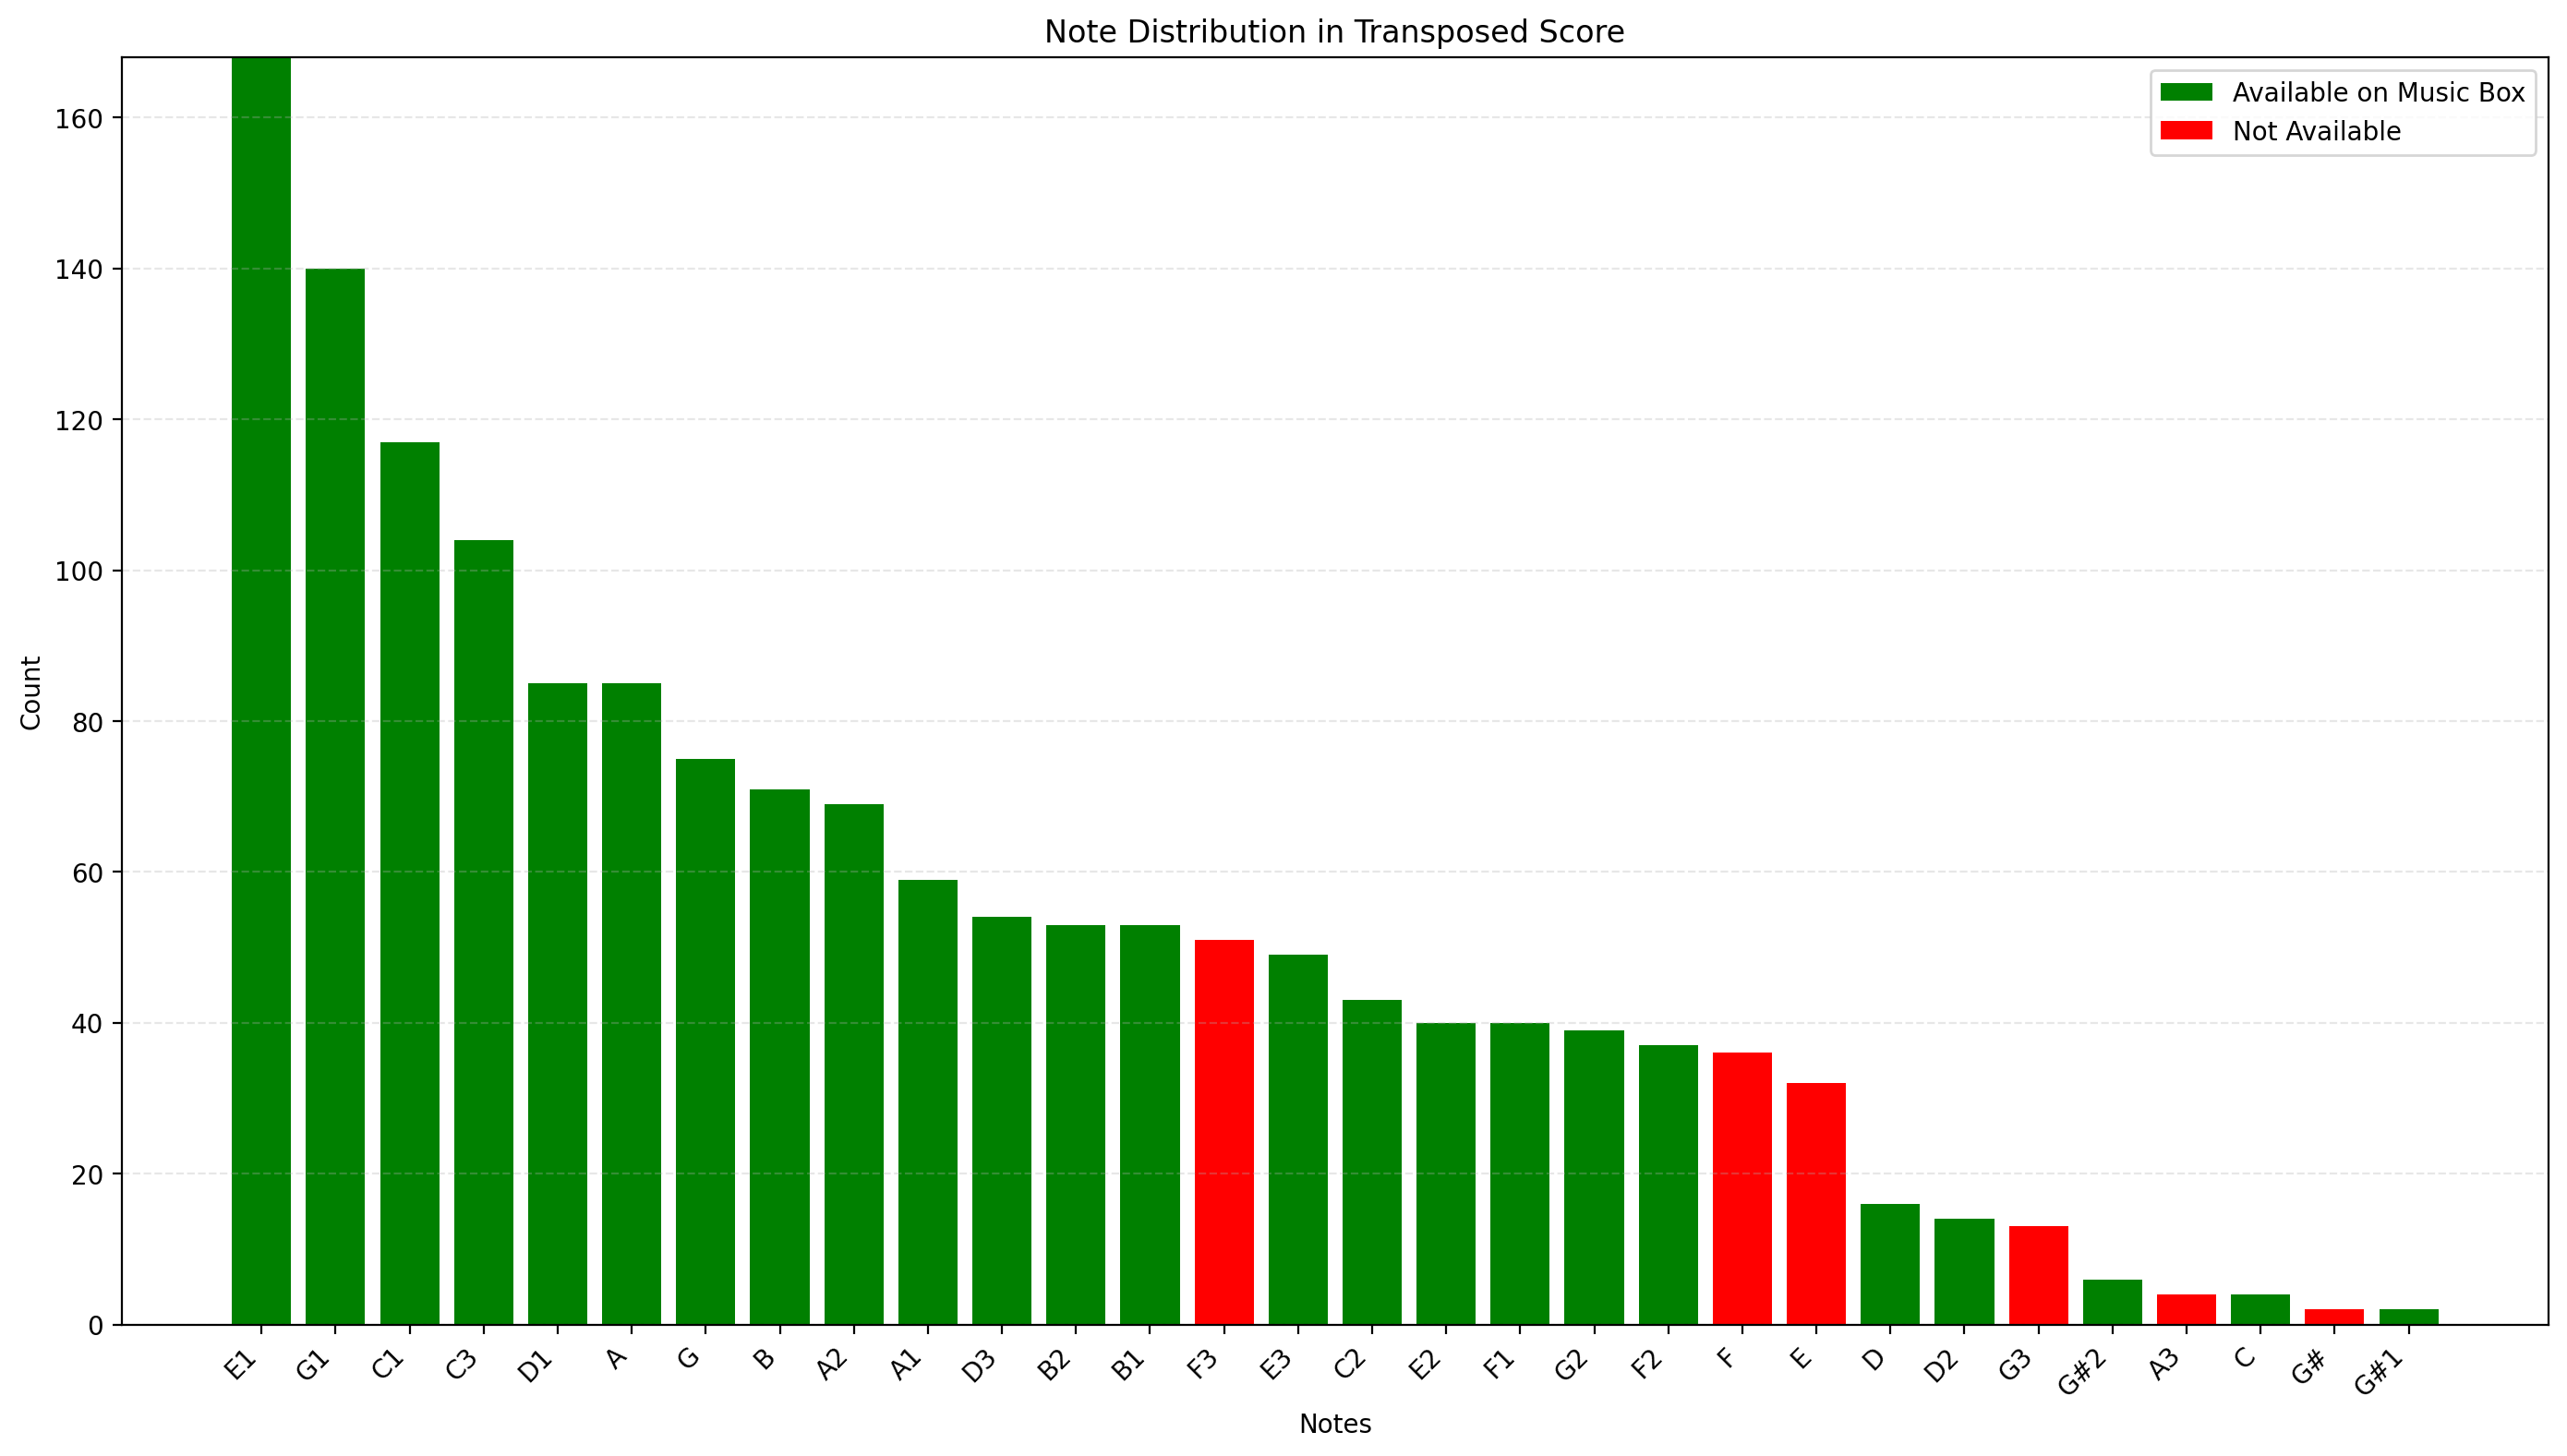

In [121]:
def create_transposed_score(score, semitones, output_path):
    """Create a transposed version of the entire score"""
    import copy
    
    # Create a deep copy of the score
    transposed_score = copy.deepcopy(score)
    
    # Transpose all parts
    for part in transposed_score.parts:
        for note_obj in part.flatten().notesAndRests:
            if note_obj.isNote:
                note_obj.pitch.transpose(semitones, inPlace=True)
            elif note_obj.isChord:
                for p in note_obj.pitches:
                    p.transpose(semitones, inPlace=True)
    
    # Add a comment about the transposition
    if hasattr(transposed_score, 'metadata') and transposed_score.metadata is not None:
        if hasattr(transposed_score.metadata, 'composer') and transposed_score.metadata.composer is not None:
            transposed_score.metadata.composer = f"{transposed_score.metadata.composer} (Transposed {semitones:+d} semitones)"
    
    # Write to file
    transposed_score.write('musicxml', fp=output_path)
    return transposed_score

# Get the best overall transposition (-3 semitones as discovered previously)
best_overall_transposition = -3

# Create the transposed score
output_path = "/workspaces/codespaces-jupyter/music/transposed_for_music_box.mxl"
transposed_score = create_transposed_score(score, best_overall_transposition, output_path)

# Analyze the coverage of the transposed score
transposed_notes = []
for part in transposed_score.parts:
    for note_obj in part.flatten().notesAndRests:
        if note_obj.isNote:
            note = convert_to_music_box_notation(note_obj.pitch.nameWithOctave)
            transposed_notes.append((note_obj.offset, note, note in music_box_notes))
        elif note_obj.isChord:
            for p in note_obj.pitches:
                note = convert_to_music_box_notation(p.nameWithOctave)
                transposed_notes.append((note_obj.offset, note, note in music_box_notes))

# Calculate coverage
covered = sum(1 for _, _, avail in transposed_notes if avail)
total = len(transposed_notes)
coverage = covered / total if total else 0

print(f"\nTransposed Score Analysis:")
print(f"Transposition: {best_overall_transposition:+d} semitones")
print(f"Coverage: {covered}/{total} notes ({coverage*100:.1f}%)")

# Create a timeline visualization of the coverage
plt.figure(figsize=(15, 6))
offsets = [n[0] for n in transposed_notes]
covered_status = [1 if n[2] else 0 for n in transposed_notes]
colors = ['green' if c else 'red' for c in covered_status]

plt.scatter(offsets, covered_status, c=colors, s=30, alpha=0.7)
plt.yticks([0, 1], ['Not Available', 'Available'])
plt.title(f'Music Box Coverage Timeline (Transposed by {best_overall_transposition:+d} semitones)')
plt.xlabel('Score Position (Quarter Notes)')
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Add a note distribution visualization
note_counts = {}
for _, note, available in transposed_notes:
    if note not in note_counts:
        note_counts[note] = {'available': 0, 'unavailable': 0}
    
    if available:
        note_counts[note]['available'] += 1
    else:
        note_counts[note]['unavailable'] += 1

# Sort notes by their occurrence
sorted_notes = sorted(note_counts.items(), key=lambda x: x[1]['available'] + x[1]['unavailable'], reverse=True)

# Plot the distribution
plt.figure(figsize=(14, 8))
notes = [n[0] for n in sorted_notes]
available = [n[1]['available'] for n in sorted_notes]
unavailable = [n[1]['unavailable'] for n in sorted_notes]

plt.bar(notes, available, label='Available on Music Box', color='green')
plt.bar(notes, unavailable, bottom=available, label='Not Available', color='red')
plt.title('Note Distribution in Transposed Score')
plt.xlabel('Notes')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()